In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt 

for img in os.listdir("/content/drive/MyDrive/Bioimaging/A0.3"):
    img_array = cv2.imread(os.path.join("/content/drive/MyDrive/Bioimaging/A0.3", img))
    img_array = cv2.resize(img_array, (32, 32))
    #remove the _0.3 from the name of the image and replace it with ""
    img_name = img.replace("_0.3", "")
    #save the image in the folder train/LR
    cv2.imwrite(os.path.join("/content/train/LR", img_name), img_array)

for img in os.listdir("/content/drive/MyDrive/Bioimaging/A0.7"):
    img_array = cv2.imread(os.path.join("/content/drive/MyDrive/Bioimaging/A0.7", img))
    img_array = cv2.resize(img_array, (128, 128))
    #remove the _0.7 from the name of the image and replace it with ""
    img_name = img.replace("_0.7", "")
    #save the image in the folder train/LR
    cv2.imwrite(os.path.join("/content/train/HR", img_name), img_array)


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [5]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

###################################################################################

Done with loading images


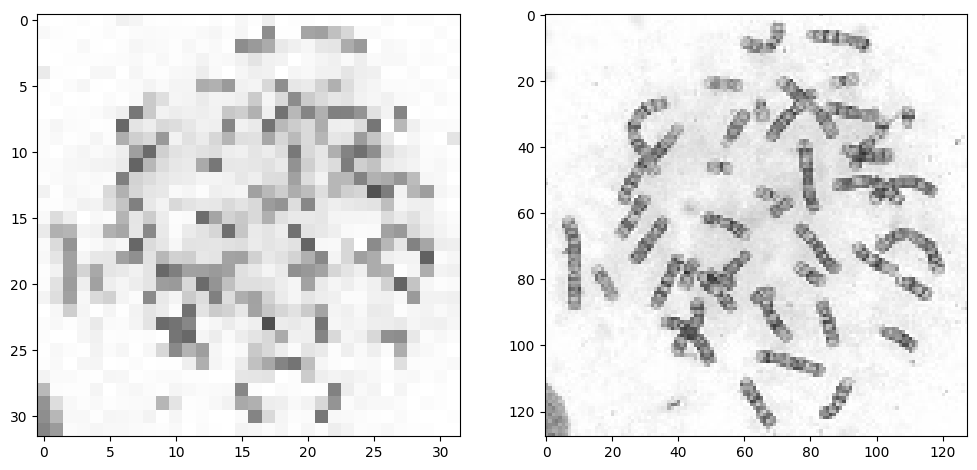

In [6]:
n=1000
lr_list = os.listdir("/content/train/LR")[:n]
lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/train/LR/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("/content/train/HR")[:n]
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/train/HR/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

print("Done with loading images")
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()



In [7]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

print("Done with scaling images")
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

print("Done with splitting images")



Done with scaling images
Done with splitting images


In [8]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [9]:

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)


# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

print("Done with creating models")



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [10]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 5
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/content/gen_e_"+ str(e+1) +".h5")

print("Done with training")

from keras.models import load_model
from numpy.random import randint


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

print("Done with testing")

################################################
sreeni_lr = cv2.imread("data/sreeni_32.jpg")
sreeni_hr = cv2.imread("data/sreeni_256.jpg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()

  0%|          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 1s 614ms/step


  0%|          | 1/670 [00:44<8:15:06, 44.40s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/670 [00:44<3:24:55, 18.41s/it]

1/1 [==============================] - 0s 19ms/step


  0%|          | 3/670 [00:44<1:52:10, 10.09s/it]

1/1 [==============================] - 0s 20ms/step


  1%|          | 4/670 [00:44<1:08:36,  6.18s/it]

1/1 [==============================] - 0s 21ms/step


  1%|          | 5/670 [00:45<44:32,  4.02s/it]  

1/1 [==============================] - 0s 22ms/step


  1%|          | 6/670 [00:45<30:02,  2.71s/it]

1/1 [==============================] - 0s 19ms/step


  1%|          | 7/670 [00:45<20:49,  1.89s/it]

1/1 [==============================] - 0s 21ms/step


  1%|          | 8/670 [00:45<14:49,  1.34s/it]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 9/670 [00:45<10:51,  1.01it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 10/670 [00:46<08:06,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 11/670 [00:46<06:11,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 12/670 [00:46<04:51,  2.26it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 13/670 [00:46<03:58,  2.76it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 14/670 [00:46<03:19,  3.29it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 15/670 [00:46<02:53,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 16/670 [00:47<02:36,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 17/670 [00:47<02:22,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 18/670 [00:47<02:11,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 19/670 [00:47<02:05,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 20/670 [00:47<02:02,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 21/670 [00:47<01:59,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 22/670 [00:48<01:55,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 23/670 [00:48<01:56,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 24/670 [00:48<01:55,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 25/670 [00:48<01:54,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 26/670 [00:48<01:55,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 27/670 [00:49<01:55,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 28/670 [00:49<01:52,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 29/670 [00:49<01:50,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 30/670 [00:49<01:47,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 31/670 [00:49<01:46,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 32/670 [00:49<01:50,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 33/670 [00:50<01:49,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 34/670 [00:50<01:47,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 35/670 [00:50<01:45,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 36/670 [00:50<01:44,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 37/670 [00:50<01:43,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 38/670 [00:50<01:44,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 39/670 [00:51<01:44,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 40/670 [00:51<01:44,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 41/670 [00:51<01:43,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 42/670 [00:51<01:41,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 43/670 [00:51<01:40,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 44/670 [00:51<01:40,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 45/670 [00:52<01:42,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 46/670 [00:52<01:41,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 47/670 [00:52<01:45,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 48/670 [00:52<01:43,  6.03it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 49/670 [00:52<01:53,  5.46it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 50/670 [00:52<02:05,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 51/670 [00:53<02:11,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 52/670 [00:53<02:15,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 53/670 [00:53<02:13,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 54/670 [00:53<02:16,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 55/670 [00:54<02:21,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 56/670 [00:54<02:20,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 57/670 [00:54<02:21,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 58/670 [00:54<02:22,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 59/670 [00:55<02:22,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 60/670 [00:55<02:18,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 61/670 [00:55<02:07,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 62/670 [00:55<01:59,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 63/670 [00:55<01:53,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 64/670 [00:55<01:49,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 65/670 [00:56<01:48,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 66/670 [00:56<01:46,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 67/670 [00:56<01:44,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 68/670 [00:56<01:41,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 69/670 [00:56<01:44,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 70/670 [00:56<01:42,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 71/670 [00:57<01:42,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 72/670 [00:57<01:41,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 73/670 [00:57<01:41,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 74/670 [00:57<01:43,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 75/670 [00:57<01:40,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 76/670 [00:58<01:40,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 77/670 [00:58<01:39,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 78/670 [00:58<01:38,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 79/670 [00:58<01:37,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 80/670 [00:58<01:39,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 81/670 [00:58<01:39,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 82/670 [00:59<01:42,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 83/670 [00:59<01:41,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 84/670 [00:59<01:39,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 85/670 [00:59<01:37,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 86/670 [00:59<01:35,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 87/670 [00:59<01:40,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 88/670 [01:00<01:42,  5.68it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 89/670 [01:00<01:43,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 90/670 [01:00<01:40,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 91/670 [01:00<01:38,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 92/670 [01:00<01:37,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 93/670 [01:00<01:36,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 94/670 [01:01<01:38,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 95/670 [01:01<01:38,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 96/670 [01:01<01:36,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 97/670 [01:01<01:35,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 98/670 [01:01<01:34,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 99/670 [01:01<01:34,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 100/670 [01:02<01:34,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 101/670 [01:02<01:34,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 102/670 [01:02<01:35,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 103/670 [01:02<01:33,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 104/670 [01:02<01:32,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 105/670 [01:02<01:34,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 106/670 [01:03<01:33,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 107/670 [01:03<01:32,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 108/670 [01:03<01:32,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 109/670 [01:03<01:31,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 110/670 [01:03<01:30,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 111/670 [01:03<01:32,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 112/670 [01:04<01:31,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 113/670 [01:04<01:32,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 114/670 [01:04<01:32,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 115/670 [01:04<01:30,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 116/670 [01:04<01:30,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 117/670 [01:04<01:29,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 118/670 [01:05<01:30,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 119/670 [01:05<01:30,  6.08it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 120/670 [01:05<01:42,  5.39it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 121/670 [01:05<01:49,  5.02it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 122/670 [01:05<01:53,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 123/670 [01:06<01:55,  4.74it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 124/670 [01:06<02:04,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 125/670 [01:06<02:02,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 126/670 [01:06<02:04,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 127/670 [01:07<02:05,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 128/670 [01:07<02:04,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 129/670 [01:07<02:05,  4.32it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 130/670 [01:07<02:10,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 131/670 [01:08<02:08,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 132/670 [01:08<01:59,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 133/670 [01:08<01:50,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 134/670 [01:08<01:44,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 135/670 [01:08<01:39,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 136/670 [01:08<01:36,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 137/670 [01:09<01:36,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 138/670 [01:09<01:36,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 139/670 [01:09<01:34,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 140/670 [01:09<01:32,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 141/670 [01:09<01:31,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 142/670 [01:09<01:32,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 143/670 [01:10<01:30,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 144/670 [01:10<01:30,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 145/670 [01:10<01:29,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 146/670 [01:10<01:32,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 147/670 [01:10<01:31,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 148/670 [01:10<01:30,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 149/670 [01:11<01:29,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 150/670 [01:11<01:28,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 151/670 [01:11<01:27,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 152/670 [01:11<01:27,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 153/670 [01:11<01:27,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 154/670 [01:11<01:27,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 155/670 [01:12<01:27,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 156/670 [01:12<01:26,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 157/670 [01:12<01:27,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 158/670 [01:12<01:28,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 159/670 [01:12<01:27,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 160/670 [01:12<01:26,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 161/670 [01:13<01:27,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 162/670 [01:13<01:28,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 163/670 [01:13<01:32,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 164/670 [01:13<01:31,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 165/670 [01:13<01:28,  5.70it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 166/670 [01:14<01:28,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 167/670 [01:14<01:27,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 168/670 [01:14<01:25,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 169/670 [01:14<01:25,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 170/670 [01:14<01:25,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 171/670 [01:14<01:25,  5.83it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 172/670 [01:15<01:26,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 173/670 [01:15<01:26,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 174/670 [01:15<01:26,  5.74it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 175/670 [01:15<01:26,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 176/670 [01:15<01:24,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 177/670 [01:15<01:24,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 178/670 [01:16<01:26,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 179/670 [01:16<01:27,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 180/670 [01:16<01:26,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 181/670 [01:16<01:27,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 182/670 [01:16<01:25,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 183/670 [01:17<01:25,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 184/670 [01:17<01:23,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 185/670 [01:17<01:22,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 186/670 [01:17<01:24,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 187/670 [01:17<01:23,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 188/670 [01:17<01:22,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 189/670 [01:18<01:23,  5.74it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 190/670 [01:18<01:30,  5.28it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 191/670 [01:18<01:37,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 192/670 [01:18<01:43,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 193/670 [01:19<01:47,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 194/670 [01:19<01:50,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 195/670 [01:19<01:48,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 196/670 [01:19<01:51,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 197/670 [01:19<01:50,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 198/670 [01:20<01:53,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 199/670 [01:20<01:55,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 200/670 [01:20<01:54,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 201/670 [01:20<01:48,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 202/670 [01:21<01:44,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 203/670 [01:21<01:39,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 204/670 [01:21<01:36,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 205/670 [01:21<01:32,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 206/670 [01:21<01:29,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 207/670 [01:22<01:27,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 208/670 [01:22<01:25,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 209/670 [01:22<01:24,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 210/670 [01:22<01:21,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 211/670 [01:22<01:21,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 212/670 [01:22<01:23,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 213/670 [01:23<01:23,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 214/670 [01:23<01:22,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 215/670 [01:23<01:20,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 216/670 [01:23<01:19,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 217/670 [01:23<01:20,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 218/670 [01:23<01:20,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 219/670 [01:24<01:19,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 220/670 [01:24<01:19,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 221/670 [01:24<01:18,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 222/670 [01:24<01:18,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 223/670 [01:24<01:18,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 224/670 [01:25<01:17,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 225/670 [01:25<01:16,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 226/670 [01:25<01:16,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 227/670 [01:25<01:15,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 228/670 [01:25<01:15,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 229/670 [01:25<01:16,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 230/670 [01:26<01:16,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 231/670 [01:26<01:16,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 232/670 [01:26<01:15,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 233/670 [01:26<01:14,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 234/670 [01:26<01:13,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 235/670 [01:26<01:16,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 236/670 [01:27<01:17,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 237/670 [01:27<01:16,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 238/670 [01:27<01:16,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 239/670 [01:27<01:15,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 240/670 [01:27<01:14,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 241/670 [01:27<01:15,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 242/670 [01:28<01:14,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 243/670 [01:28<01:13,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 244/670 [01:28<01:12,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 245/670 [01:28<01:12,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 246/670 [01:28<01:11,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 247/670 [01:29<01:12,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 248/670 [01:29<01:11,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 249/670 [01:29<01:11,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 250/670 [01:29<01:11,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 251/670 [01:29<01:11,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 252/670 [01:29<01:10,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 253/670 [01:30<01:12,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 254/670 [01:30<01:11,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 255/670 [01:30<01:10,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 256/670 [01:30<01:11,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 257/670 [01:30<01:10,  5.82it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 258/670 [01:30<01:15,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 259/670 [01:31<01:22,  4.97it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 260/670 [01:31<01:25,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 261/670 [01:31<01:27,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 262/670 [01:31<01:32,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 263/670 [01:32<01:33,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 264/670 [01:32<01:36,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 265/670 [01:32<01:36,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 266/670 [01:32<01:34,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 267/670 [01:33<01:37,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 268/670 [01:33<01:38,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 269/670 [01:33<01:39,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 270/670 [01:33<01:33,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 271/670 [01:33<01:27,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 272/670 [01:34<01:23,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 273/670 [01:34<01:20,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 274/670 [01:34<01:17,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 275/670 [01:34<01:15,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 276/670 [01:34<01:13,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 277/670 [01:35<01:12,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 278/670 [01:35<01:12,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 279/670 [01:35<01:11,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 280/670 [01:35<01:10,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 281/670 [01:35<01:09,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 282/670 [01:35<01:08,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 283/670 [01:36<01:12,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 284/670 [01:36<01:11,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 285/670 [01:36<01:10,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 286/670 [01:36<01:09,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 287/670 [01:36<01:08,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 288/670 [01:37<01:08,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 289/670 [01:37<01:08,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 290/670 [01:37<01:07,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 291/670 [01:37<01:06,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 292/670 [01:37<01:06,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 293/670 [01:37<01:06,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 294/670 [01:38<01:06,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 295/670 [01:38<01:06,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 296/670 [01:38<01:06,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 297/670 [01:38<01:06,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 298/670 [01:38<01:04,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 299/670 [01:38<01:04,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 300/670 [01:39<01:04,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 301/670 [01:39<01:05,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 302/670 [01:39<01:04,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 303/670 [01:39<01:07,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 304/670 [01:39<01:06,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 305/670 [01:40<01:05,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 306/670 [01:40<01:05,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 307/670 [01:40<01:05,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 308/670 [01:40<01:04,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 309/670 [01:40<01:03,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 310/670 [01:40<01:03,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 311/670 [01:41<01:04,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 312/670 [01:41<01:03,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 313/670 [01:41<01:03,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 314/670 [01:41<01:02,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 315/670 [01:41<01:01,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 316/670 [01:42<01:01,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 317/670 [01:42<01:02,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 318/670 [01:42<01:01,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 319/670 [01:42<01:01,  5.75it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 320/670 [01:42<01:03,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 321/670 [01:42<01:01,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 322/670 [01:43<01:00,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 323/670 [01:43<01:01,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 324/670 [01:43<01:02,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 325/670 [01:43<01:03,  5.40it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 326/670 [01:43<01:09,  4.97it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 327/670 [01:44<01:12,  4.72it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 328/670 [01:44<01:16,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 329/670 [01:44<01:17,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 330/670 [01:44<01:16,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 331/670 [01:45<01:17,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 332/670 [01:45<01:21,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 333/670 [01:45<01:21,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 334/670 [01:45<01:20,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 335/670 [01:46<01:21,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 336/670 [01:46<01:21,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 337/670 [01:46<01:19,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 338/670 [01:46<01:15,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 339/670 [01:46<01:11,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 340/670 [01:47<01:07,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 341/670 [01:47<01:05,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 342/670 [01:47<01:03,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 343/670 [01:47<01:02,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 344/670 [01:47<01:02,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 345/670 [01:48<01:00,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 346/670 [01:48<01:00,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 347/670 [01:48<00:58,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 348/670 [01:48<00:58,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 349/670 [01:48<00:57,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 350/670 [01:48<00:57,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 351/670 [01:49<00:56,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 352/670 [01:49<00:57,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 353/670 [01:49<00:57,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 354/670 [01:49<00:56,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 355/670 [01:49<00:55,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 356/670 [01:49<00:55,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 357/670 [01:50<00:54,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 358/670 [01:50<00:54,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 359/670 [01:50<00:55,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 360/670 [01:50<00:55,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 361/670 [01:50<00:54,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 362/670 [01:51<00:54,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 363/670 [01:51<00:53,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 364/670 [01:51<00:53,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 365/670 [01:51<00:53,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 366/670 [01:51<00:53,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 367/670 [01:51<00:52,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 368/670 [01:52<00:53,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 369/670 [01:52<00:54,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 370/670 [01:52<00:53,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 371/670 [01:52<00:53,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 372/670 [01:52<00:53,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 373/670 [01:52<00:53,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 374/670 [01:53<00:52,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 375/670 [01:53<00:51,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 376/670 [01:53<00:52,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 377/670 [01:53<00:53,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 378/670 [01:53<00:52,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 379/670 [01:54<00:52,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 380/670 [01:54<00:51,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 381/670 [01:54<00:50,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 382/670 [01:54<00:50,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 383/670 [01:54<00:49,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 384/670 [01:54<00:51,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 385/670 [01:55<00:51,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 386/670 [01:55<00:51,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 387/670 [01:55<00:50,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 388/670 [01:55<00:50,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 389/670 [01:55<00:49,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 390/670 [01:55<00:48,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 391/670 [01:56<00:48,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 392/670 [01:56<00:48,  5.75it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 393/670 [01:56<00:52,  5.31it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 394/670 [01:56<00:57,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 395/670 [01:57<00:59,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 396/670 [01:57<01:00,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 397/670 [01:57<01:02,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 398/670 [01:57<01:03,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 399/670 [01:57<01:02,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 400/670 [01:58<01:01,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 401/670 [01:58<01:01,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 402/670 [01:58<01:02,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 403/670 [01:58<01:03,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 404/670 [01:59<01:05,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 405/670 [01:59<01:01,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 406/670 [01:59<00:57,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 407/670 [01:59<00:54,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 408/670 [01:59<00:52,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 409/670 [02:00<00:50,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 410/670 [02:00<00:50,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 411/670 [02:00<00:49,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 412/670 [02:00<00:48,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 413/670 [02:00<00:48,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 414/670 [02:01<00:47,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 415/670 [02:01<00:46,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 416/670 [02:01<00:45,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 417/670 [02:01<00:45,  5.61it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 418/670 [02:01<00:45,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 419/670 [02:01<00:45,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 420/670 [02:02<00:44,  5.61it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 421/670 [02:02<00:43,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 422/670 [02:02<00:43,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 423/670 [02:02<00:42,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 424/670 [02:02<00:42,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 425/670 [02:02<00:42,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 426/670 [02:03<00:42,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 427/670 [02:03<00:42,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 428/670 [02:03<00:42,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 429/670 [02:03<00:41,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 430/670 [02:03<00:41,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 431/670 [02:04<00:41,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 432/670 [02:04<00:42,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 433/670 [02:04<00:41,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 434/670 [02:04<00:40,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 435/670 [02:04<00:40,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 436/670 [02:04<00:40,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 437/670 [02:05<00:40,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 438/670 [02:05<00:40,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 439/670 [02:05<00:39,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 440/670 [02:05<00:38,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 441/670 [02:05<00:38,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 442/670 [02:05<00:39,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 443/670 [02:06<00:40,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 444/670 [02:06<00:39,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 445/670 [02:06<00:39,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 446/670 [02:06<00:38,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 447/670 [02:06<00:38,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 448/670 [02:06<00:38,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 449/670 [02:07<00:38,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 450/670 [02:07<00:39,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 451/670 [02:07<00:39,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 452/670 [02:07<00:39,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 453/670 [02:07<00:39,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 454/670 [02:08<00:38,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 455/670 [02:08<00:38,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 456/670 [02:08<00:37,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 457/670 [02:08<00:37,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 458/670 [02:08<00:37,  5.65it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 459/670 [02:08<00:38,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 460/670 [02:09<00:37,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 461/670 [02:09<00:37,  5.50it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 462/670 [02:09<00:42,  4.93it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 463/670 [02:09<00:43,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 464/670 [02:10<00:45,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 465/670 [02:10<00:45,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 466/670 [02:10<00:45,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 467/670 [02:10<00:46,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 468/670 [02:10<00:47,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 469/670 [02:11<00:47,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 470/670 [02:11<00:48,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 471/670 [02:11<00:48,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 472/670 [02:12<00:49,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 473/670 [02:12<00:47,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 474/670 [02:12<00:44,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 475/670 [02:12<00:41,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 476/670 [02:12<00:40,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 477/670 [02:12<00:38,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 478/670 [02:13<00:37,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 479/670 [02:13<00:37,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 480/670 [02:13<00:36,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 481/670 [02:13<00:36,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 482/670 [02:13<00:35,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 483/670 [02:14<00:35,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 484/670 [02:14<00:34,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 485/670 [02:14<00:34,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 486/670 [02:14<00:33,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 487/670 [02:14<00:33,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 488/670 [02:14<00:32,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 489/670 [02:15<00:32,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 490/670 [02:15<00:32,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 491/670 [02:15<00:32,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 492/670 [02:15<00:32,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 493/670 [02:15<00:32,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 494/670 [02:16<00:32,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 495/670 [02:16<00:31,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 496/670 [02:16<00:31,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 497/670 [02:16<00:31,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 498/670 [02:16<00:31,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 499/670 [02:16<00:30,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 500/670 [02:17<00:31,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 501/670 [02:17<00:31,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 502/670 [02:17<00:31,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 503/670 [02:17<00:30,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 504/670 [02:17<00:30,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 505/670 [02:18<00:30,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 506/670 [02:18<00:30,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 507/670 [02:18<00:30,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 508/670 [02:18<00:29,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 509/670 [02:18<00:29,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 510/670 [02:19<00:28,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 511/670 [02:19<00:28,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 512/670 [02:19<00:28,  5.55it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 513/670 [02:19<00:29,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 514/670 [02:19<00:28,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 515/670 [02:19<00:28,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 516/670 [02:20<00:28,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 517/670 [02:20<00:28,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 518/670 [02:20<00:27,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 519/670 [02:20<00:27,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 520/670 [02:20<00:26,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 521/670 [02:21<00:26,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 522/670 [02:21<00:26,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 523/670 [02:21<00:26,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 524/670 [02:21<00:26,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 525/670 [02:21<00:26,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 526/670 [02:21<00:25,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 527/670 [02:22<00:25,  5.63it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 528/670 [02:22<00:28,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 529/670 [02:22<00:30,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 530/670 [02:22<00:30,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 531/670 [02:23<00:31,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 532/670 [02:23<00:31,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 533/670 [02:23<00:31,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 534/670 [02:23<00:32,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 535/670 [02:24<00:33,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 536/670 [02:24<00:33,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 537/670 [02:24<00:32,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 538/670 [02:24<00:32,  4.03it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 539/670 [02:25<00:31,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 540/670 [02:25<00:29,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 541/670 [02:25<00:28,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 542/670 [02:25<00:27,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 543/670 [02:25<00:26,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 544/670 [02:26<00:25,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 545/670 [02:26<00:24,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 546/670 [02:26<00:24,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 547/670 [02:26<00:23,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 548/670 [02:26<00:22,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 549/670 [02:26<00:22,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 550/670 [02:27<00:22,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 551/670 [02:27<00:21,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 552/670 [02:27<00:21,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 553/670 [02:27<00:21,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 554/670 [02:27<00:21,  5.43it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 555/670 [02:28<00:21,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 556/670 [02:28<00:21,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 557/670 [02:28<00:20,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 558/670 [02:28<00:20,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 559/670 [02:28<00:20,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 560/670 [02:28<00:20,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 561/670 [02:29<00:20,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 562/670 [02:29<00:20,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 563/670 [02:29<00:19,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 564/670 [02:29<00:19,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 565/670 [02:29<00:19,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 566/670 [02:30<00:19,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 567/670 [02:30<00:19,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 568/670 [02:30<00:19,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 569/670 [02:30<00:18,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 570/670 [02:30<00:18,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 571/670 [02:31<00:18,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 572/670 [02:31<00:17,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 573/670 [02:31<00:17,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 574/670 [02:31<00:17,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 575/670 [02:31<00:17,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 576/670 [02:31<00:16,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 577/670 [02:32<00:16,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 578/670 [02:32<00:16,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 579/670 [02:32<00:16,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 580/670 [02:32<00:16,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 581/670 [02:32<00:16,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 582/670 [02:32<00:15,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 583/670 [02:33<00:15,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 584/670 [02:33<00:15,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 585/670 [02:33<00:15,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 586/670 [02:33<00:15,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 587/670 [02:33<00:14,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 588/670 [02:34<00:14,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 589/670 [02:34<00:14,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 590/670 [02:34<00:14,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 591/670 [02:34<00:14,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 592/670 [02:34<00:14,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 593/670 [02:34<00:13,  5.56it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 594/670 [02:35<00:15,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 595/670 [02:35<00:16,  4.62it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 596/670 [02:35<00:16,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 597/670 [02:35<00:16,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 598/670 [02:36<00:16,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 599/670 [02:36<00:16,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 600/670 [02:36<00:16,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 601/670 [02:36<00:16,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 602/670 [02:37<00:16,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 603/670 [02:37<00:16,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 604/670 [02:37<00:16,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 605/670 [02:37<00:16,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 606/670 [02:38<00:14,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 607/670 [02:38<00:13,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 608/670 [02:38<00:13,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 609/670 [02:38<00:12,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 610/670 [02:38<00:12,  4.85it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 611/670 [02:39<00:12,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 612/670 [02:39<00:11,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 613/670 [02:39<00:11,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 614/670 [02:39<00:10,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 615/670 [02:39<00:10,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 616/670 [02:40<00:10,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 617/670 [02:40<00:10,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 618/670 [02:40<00:09,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 619/670 [02:40<00:09,  5.29it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 620/670 [02:40<00:09,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 621/670 [02:40<00:09,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 622/670 [02:41<00:08,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 623/670 [02:41<00:08,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 624/670 [02:41<00:08,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 625/670 [02:41<00:08,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 626/670 [02:41<00:08,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 627/670 [02:42<00:08,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 628/670 [02:42<00:07,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 629/670 [02:42<00:07,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 630/670 [02:42<00:07,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 631/670 [02:42<00:07,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 632/670 [02:43<00:07,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 633/670 [02:43<00:06,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 634/670 [02:43<00:06,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 635/670 [02:43<00:06,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 636/670 [02:43<00:06,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 637/670 [02:43<00:06,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 638/670 [02:44<00:06,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 639/670 [02:44<00:05,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 640/670 [02:44<00:05,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 641/670 [02:44<00:05,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 642/670 [02:44<00:05,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 643/670 [02:45<00:04,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 644/670 [02:45<00:04,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 645/670 [02:45<00:04,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 646/670 [02:45<00:04,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 647/670 [02:45<00:04,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 648/670 [02:46<00:04,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 649/670 [02:46<00:04,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 650/670 [02:46<00:03,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 651/670 [02:46<00:03,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 652/670 [02:46<00:03,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 653/670 [02:46<00:03,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 654/670 [02:47<00:03,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 655/670 [02:47<00:02,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 656/670 [02:47<00:02,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 657/670 [02:47<00:02,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 658/670 [02:47<00:02,  5.27it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 659/670 [02:48<00:02,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 660/670 [02:48<00:02,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 661/670 [02:48<00:02,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 662/670 [02:48<00:01,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 663/670 [02:49<00:01,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 664/670 [02:49<00:01,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 665/670 [02:49<00:01,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 666/670 [02:49<00:00,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 667/670 [02:50<00:00,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 668/670 [02:50<00:00,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 669/670 [02:50<00:00,  3.90it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 670/670 [02:50<00:00,  3.92it/s]


epoch: 1 g_loss: 77.63353552747128 d_loss: [2.87786285 0.92164179]


  0%|          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 1/670 [00:00<02:16,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 2/670 [00:00<02:12,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 3/670 [00:00<02:13,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/670 [00:00<02:12,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 5/670 [00:01<02:16,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 6/670 [00:01<02:14,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 7/670 [00:01<02:11,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 8/670 [00:01<02:10,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 9/670 [00:01<02:09,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 10/670 [00:01<02:08,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 11/670 [00:02<02:08,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 12/670 [00:02<02:07,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 13/670 [00:02<02:06,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 14/670 [00:02<02:07,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 15/670 [00:02<02:05,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 16/670 [00:03<02:05,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 17/670 [00:03<02:04,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 18/670 [00:03<02:03,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 19/670 [00:03<02:03,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 20/670 [00:03<02:03,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 21/670 [00:04<02:05,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 22/670 [00:04<02:05,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 23/670 [00:04<02:04,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 24/670 [00:04<02:03,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 25/670 [00:04<02:01,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 26/670 [00:05<02:00,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 27/670 [00:05<02:00,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 28/670 [00:05<02:00,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 29/670 [00:05<01:59,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 30/670 [00:05<01:59,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 31/670 [00:05<01:57,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 32/670 [00:06<01:57,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 33/670 [00:06<01:58,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 34/670 [00:06<01:58,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 35/670 [00:06<01:59,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 36/670 [00:06<01:58,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 37/670 [00:07<01:56,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 38/670 [00:07<01:56,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 39/670 [00:07<01:57,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 40/670 [00:07<01:58,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 41/670 [00:07<01:56,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 42/670 [00:08<01:58,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 43/670 [00:08<02:02,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 44/670 [00:08<02:01,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 45/670 [00:08<02:00,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 46/670 [00:08<01:58,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 47/670 [00:08<01:57,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 48/670 [00:09<02:01,  5.13it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 49/670 [00:09<02:05,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 50/670 [00:09<02:05,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 51/670 [00:09<02:03,  5.02it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 52/670 [00:10<02:09,  4.75it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 53/670 [00:10<02:17,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 54/670 [00:10<02:22,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 55/670 [00:10<02:26,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 56/670 [00:11<02:25,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 57/670 [00:11<02:30,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 58/670 [00:11<02:33,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 59/670 [00:11<02:27,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 60/670 [00:12<02:26,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 61/670 [00:12<02:27,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 62/670 [00:12<02:38,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 63/670 [00:12<02:36,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 64/670 [00:13<02:26,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 65/670 [00:13<02:22,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 66/670 [00:13<02:17,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 67/670 [00:13<02:11,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 68/670 [00:13<02:06,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 69/670 [00:14<02:02,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 70/670 [00:14<01:59,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 71/670 [00:14<01:57,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 72/670 [00:14<01:58,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 73/670 [00:14<01:58,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 74/670 [00:14<01:56,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 75/670 [00:15<01:56,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 76/670 [00:15<01:58,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 77/670 [00:15<01:56,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 78/670 [00:15<01:53,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 79/670 [00:15<01:52,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 80/670 [00:16<01:54,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 81/670 [00:16<01:51,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 82/670 [00:16<01:53,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 83/670 [00:16<01:51,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 84/670 [00:16<01:50,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 85/670 [00:17<01:50,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 86/670 [00:17<01:49,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 87/670 [00:17<01:50,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 88/670 [00:17<01:49,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 89/670 [00:17<01:49,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 90/670 [00:18<01:49,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 91/670 [00:18<01:48,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 92/670 [00:18<01:47,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 93/670 [00:18<01:46,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 94/670 [00:18<01:49,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 95/670 [00:18<01:48,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 96/670 [00:19<01:47,  5.33it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 97/670 [00:19<01:50,  5.20it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 98/670 [00:19<01:49,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 99/670 [00:19<01:48,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 100/670 [00:19<01:46,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 101/670 [00:20<01:46,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 102/670 [00:20<01:45,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 103/670 [00:20<01:45,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 104/670 [00:20<01:47,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 105/670 [00:20<01:47,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 106/670 [00:21<01:48,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 107/670 [00:21<01:48,  5.18it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 108/670 [00:21<01:46,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 109/670 [00:21<01:46,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 110/670 [00:21<01:46,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 111/670 [00:21<01:44,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 112/670 [00:22<01:44,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 113/670 [00:22<01:44,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 114/670 [00:22<01:48,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 115/670 [00:22<01:51,  4.99it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 116/670 [00:23<02:01,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 117/670 [00:23<02:09,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 118/670 [00:23<02:14,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 119/670 [00:23<02:14,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 120/670 [00:24<02:15,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 121/670 [00:24<02:17,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 122/670 [00:24<02:16,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 123/670 [00:24<02:18,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 124/670 [00:25<02:20,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 125/670 [00:25<02:18,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 126/670 [00:25<02:18,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 127/670 [00:25<02:10,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 128/670 [00:26<02:03,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 129/670 [00:26<01:57,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 130/670 [00:26<01:53,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 131/670 [00:26<01:52,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 132/670 [00:26<01:51,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 133/670 [00:27<01:50,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 134/670 [00:27<01:46,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 135/670 [00:27<01:46,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 136/670 [00:27<01:43,  5.15it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 137/670 [00:27<01:43,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 138/670 [00:27<01:42,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 139/670 [00:28<01:45,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 140/670 [00:28<01:43,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 141/670 [00:28<01:42,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 142/670 [00:28<01:42,  5.15it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 143/670 [00:28<01:42,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 144/670 [00:29<01:43,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 145/670 [00:29<01:42,  5.13it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 146/670 [00:29<01:45,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 147/670 [00:29<01:44,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 148/670 [00:29<01:42,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 149/670 [00:30<01:43,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 150/670 [00:30<01:45,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 151/670 [00:30<01:42,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 152/670 [00:30<01:42,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 153/670 [00:30<01:41,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 154/670 [00:31<01:39,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 155/670 [00:31<01:38,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 156/670 [00:31<01:39,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 157/670 [00:31<01:38,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 158/670 [00:31<01:38,  5.21it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 159/670 [00:32<01:38,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 160/670 [00:32<01:37,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 161/670 [00:32<01:35,  5.35it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 162/670 [00:32<01:33,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 163/670 [00:32<01:34,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 164/670 [00:33<01:35,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 165/670 [00:33<01:35,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 166/670 [00:33<01:34,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 167/670 [00:33<01:33,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 168/670 [00:33<01:32,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 169/670 [00:33<01:33,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 170/670 [00:34<01:34,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 171/670 [00:34<01:33,  5.32it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 172/670 [00:34<01:33,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 173/670 [00:34<01:32,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 174/670 [00:34<01:32,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 175/670 [00:35<01:33,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 176/670 [00:35<01:32,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 177/670 [00:35<01:31,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 178/670 [00:35<01:30,  5.42it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 179/670 [00:35<01:39,  4.96it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 180/670 [00:36<01:46,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 181/670 [00:36<01:53,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 182/670 [00:36<01:57,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 183/670 [00:36<02:02,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 184/670 [00:37<02:01,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 185/670 [00:37<02:03,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 186/670 [00:37<02:02,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 187/670 [00:37<02:03,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 188/670 [00:38<02:07,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 189/670 [00:38<02:08,  3.75it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 190/670 [00:38<02:01,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 191/670 [00:38<01:54,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 192/670 [00:39<01:48,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 193/670 [00:39<01:44,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 194/670 [00:39<01:40,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 195/670 [00:39<01:38,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 196/670 [00:39<01:36,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 197/670 [00:40<01:36,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 198/670 [00:40<01:34,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 199/670 [00:40<01:32,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 200/670 [00:40<01:31,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 201/670 [00:40<01:31,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 202/670 [00:41<01:32,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 203/670 [00:41<01:31,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 204/670 [00:41<01:30,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 205/670 [00:41<01:32,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 206/670 [00:41<01:31,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 207/670 [00:42<01:30,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 208/670 [00:42<01:29,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 209/670 [00:42<01:29,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 210/670 [00:42<01:28,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 211/670 [00:42<01:27,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 212/670 [00:43<01:28,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 213/670 [00:43<01:28,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 214/670 [00:43<01:29,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 215/670 [00:43<01:28,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 216/670 [00:43<01:27,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 217/670 [00:44<01:26,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 218/670 [00:44<01:27,  5.18it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 219/670 [00:44<01:27,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 220/670 [00:44<01:26,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 221/670 [00:44<01:25,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 222/670 [00:44<01:26,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 223/670 [00:45<01:26,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 224/670 [00:45<01:25,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 225/670 [00:45<01:24,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 226/670 [00:45<01:23,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 227/670 [00:45<01:22,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 228/670 [00:46<01:21,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 229/670 [00:46<01:22,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 230/670 [00:46<01:22,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 231/670 [00:46<01:22,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 232/670 [00:46<01:21,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 233/670 [00:47<01:21,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 234/670 [00:47<01:23,  5.23it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 235/670 [00:47<01:22,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 236/670 [00:47<01:20,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 237/670 [00:47<01:20,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 238/670 [00:47<01:19,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 239/670 [00:48<01:21,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 240/670 [00:48<01:21,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 241/670 [00:48<01:20,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 242/670 [00:48<01:24,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 243/670 [00:49<01:33,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 244/670 [00:49<01:38,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 245/670 [00:49<01:39,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 246/670 [00:49<01:41,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 247/670 [00:50<01:43,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 248/670 [00:50<01:45,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 249/670 [00:50<01:46,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 250/670 [00:50<01:47,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 251/670 [00:51<01:46,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 252/670 [00:51<01:47,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 253/670 [00:51<01:47,  3.89it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 254/670 [00:51<01:39,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 255/670 [00:51<01:34,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 256/670 [00:52<01:31,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 257/670 [00:52<01:27,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 258/670 [00:52<01:24,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 259/670 [00:52<01:23,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 260/670 [00:52<01:21,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 261/670 [00:53<01:20,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 262/670 [00:53<01:19,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 263/670 [00:53<01:19,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 264/670 [00:53<01:19,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 265/670 [00:53<01:18,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 266/670 [00:54<01:19,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 267/670 [00:54<01:18,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 268/670 [00:54<01:18,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 269/670 [00:54<01:18,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 270/670 [00:54<01:17,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 271/670 [00:55<01:17,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 272/670 [00:55<01:18,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 273/670 [00:55<01:19,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 274/670 [00:55<01:18,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 275/670 [00:55<01:17,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 276/670 [00:56<01:17,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 277/670 [00:56<01:17,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 278/670 [00:56<01:17,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 279/670 [00:56<01:17,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 280/670 [00:56<01:16,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 281/670 [00:57<01:16,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 282/670 [00:57<01:17,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 283/670 [00:57<01:17,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 284/670 [00:57<01:16,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 285/670 [00:57<01:15,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 286/670 [00:58<01:13,  5.20it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 287/670 [00:58<01:13,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 288/670 [00:58<01:13,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 289/670 [00:58<01:14,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 290/670 [00:58<01:14,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 291/670 [00:59<01:14,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 292/670 [00:59<01:13,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 293/670 [00:59<01:13,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 294/670 [00:59<01:13,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 295/670 [00:59<01:12,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 296/670 [00:59<01:11,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 297/670 [01:00<01:10,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 298/670 [01:00<01:11,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 299/670 [01:00<01:11,  5.18it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 300/670 [01:00<01:13,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 301/670 [01:00<01:12,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 302/670 [01:01<01:11,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 303/670 [01:01<01:11,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 304/670 [01:01<01:11,  5.15it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 305/670 [01:01<01:18,  4.64it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 306/670 [01:02<01:23,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 307/670 [01:02<01:27,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 308/670 [01:02<01:30,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 309/670 [01:02<01:31,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 310/670 [01:03<01:32,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 311/670 [01:03<01:37,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 312/670 [01:03<01:35,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 313/670 [01:04<01:42,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 314/670 [01:04<01:41,  3.52it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 315/670 [01:04<01:34,  3.75it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 316/670 [01:04<01:28,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 317/670 [01:04<01:23,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 318/670 [01:05<01:19,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 319/670 [01:05<01:16,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 320/670 [01:05<01:14,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 321/670 [01:05<01:12,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 322/670 [01:05<01:11,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 323/670 [01:06<01:10,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 324/670 [01:06<01:10,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 325/670 [01:06<01:09,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 326/670 [01:06<01:09,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 327/670 [01:06<01:08,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 328/670 [01:07<01:08,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 329/670 [01:07<01:08,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 330/670 [01:07<01:07,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 331/670 [01:07<01:08,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 332/670 [01:07<01:07,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 333/670 [01:08<01:07,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 334/670 [01:08<01:06,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 335/670 [01:08<01:06,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 336/670 [01:08<01:05,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 337/670 [01:08<01:06,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 338/670 [01:09<01:07,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 339/670 [01:09<01:05,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 340/670 [01:09<01:06,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 341/670 [01:09<01:06,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 342/670 [01:09<01:05,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 343/670 [01:10<01:04,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 344/670 [01:10<01:04,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 345/670 [01:10<01:03,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 346/670 [01:10<01:02,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 347/670 [01:10<01:02,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 348/670 [01:11<01:03,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 349/670 [01:11<01:02,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 350/670 [01:11<01:01,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 351/670 [01:11<01:01,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 352/670 [01:11<01:00,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 353/670 [01:12<01:00,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 354/670 [01:12<00:59,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 355/670 [01:12<00:59,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 356/670 [01:12<00:59,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 357/670 [01:12<00:59,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 358/670 [01:13<00:59,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 359/670 [01:13<00:59,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 360/670 [01:13<01:00,  5.09it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 361/670 [01:13<01:01,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 362/670 [01:13<01:02,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 363/670 [01:14<01:02,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 364/670 [01:14<01:01,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 365/670 [01:14<01:02,  4.88it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 366/670 [01:14<01:07,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 367/670 [01:14<01:11,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 368/670 [01:15<01:12,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 369/670 [01:15<01:15,  4.00it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 370/670 [01:15<01:17,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 371/670 [01:16<01:17,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 372/670 [01:16<01:16,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 373/670 [01:16<01:17,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 374/670 [01:16<01:17,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 375/670 [01:17<01:18,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 376/670 [01:17<01:18,  3.73it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 377/670 [01:17<01:13,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 378/670 [01:17<01:08,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 379/670 [01:17<01:05,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 380/670 [01:18<01:03,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 381/670 [01:18<01:01,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 382/670 [01:18<00:59,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 383/670 [01:18<00:58,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 384/670 [01:18<00:56,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 385/670 [01:19<00:56,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 386/670 [01:19<00:56,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 387/670 [01:19<00:55,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 388/670 [01:19<00:54,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 389/670 [01:19<00:53,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 390/670 [01:20<00:54,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 391/670 [01:20<00:54,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 392/670 [01:20<00:54,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 393/670 [01:20<00:53,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 394/670 [01:20<00:52,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 395/670 [01:21<00:52,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 396/670 [01:21<00:52,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 397/670 [01:21<00:52,  5.22it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 398/670 [01:21<00:52,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 399/670 [01:21<00:52,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 400/670 [01:22<00:52,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 401/670 [01:22<00:53,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 402/670 [01:22<00:53,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 403/670 [01:22<00:52,  5.07it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 404/670 [01:22<00:52,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 405/670 [01:23<00:51,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 406/670 [01:23<00:52,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 407/670 [01:23<00:51,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 408/670 [01:23<00:50,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 409/670 [01:23<00:50,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 410/670 [01:24<00:51,  5.07it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 411/670 [01:24<00:50,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 412/670 [01:24<00:51,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 413/670 [01:24<00:50,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 414/670 [01:24<00:49,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 415/670 [01:24<00:49,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 416/670 [01:25<00:50,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 417/670 [01:25<00:49,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 418/670 [01:25<00:48,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 419/670 [01:25<00:48,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 420/670 [01:25<00:47,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 421/670 [01:26<00:47,  5.19it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 422/670 [01:26<00:50,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 423/670 [01:26<00:49,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 424/670 [01:26<00:49,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 425/670 [01:26<00:49,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 426/670 [01:27<00:48,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 427/670 [01:27<00:48,  5.06it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 428/670 [01:27<00:52,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 429/670 [01:27<00:53,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 430/670 [01:28<00:56,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 431/670 [01:28<00:57,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 432/670 [01:28<01:00,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 433/670 [01:28<01:00,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 434/670 [01:29<00:59,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 435/670 [01:29<01:03,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 436/670 [01:29<01:02,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 437/670 [01:30<01:02,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 438/670 [01:30<01:02,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 439/670 [01:30<00:58,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 440/670 [01:30<00:54,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 441/670 [01:30<00:52,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 442/670 [01:31<00:51,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 443/670 [01:31<00:50,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 444/670 [01:31<00:49,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 445/670 [01:31<00:47,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 446/670 [01:31<00:47,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 447/670 [01:32<00:46,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 448/670 [01:32<00:45,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 449/670 [01:32<00:44,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 450/670 [01:32<00:44,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 451/670 [01:32<00:44,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 452/670 [01:33<00:44,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 453/670 [01:33<00:44,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 454/670 [01:33<00:43,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 455/670 [01:33<00:43,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 456/670 [01:33<00:43,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 457/670 [01:34<00:43,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 458/670 [01:34<00:42,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 459/670 [01:34<00:42,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 460/670 [01:34<00:41,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 461/670 [01:34<00:41,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 462/670 [01:35<00:42,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 463/670 [01:35<00:42,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 464/670 [01:35<00:42,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 465/670 [01:35<00:41,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 466/670 [01:35<00:41,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 467/670 [01:36<00:40,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 468/670 [01:36<00:40,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 469/670 [01:36<00:40,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 470/670 [01:36<00:39,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 471/670 [01:36<00:39,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 472/670 [01:37<00:39,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 473/670 [01:37<00:39,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 474/670 [01:37<00:39,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 475/670 [01:37<00:39,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 476/670 [01:37<00:38,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 477/670 [01:38<00:38,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 478/670 [01:38<00:37,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 479/670 [01:38<00:37,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 480/670 [01:38<00:37,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 481/670 [01:38<00:36,  5.12it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 482/670 [01:39<00:37,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 483/670 [01:39<00:37,  4.96it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 484/670 [01:39<00:37,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 485/670 [01:39<00:37,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 486/670 [01:39<00:37,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 487/670 [01:40<00:36,  5.01it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 488/670 [01:40<00:38,  4.77it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 489/670 [01:40<00:41,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 490/670 [01:40<00:42,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 491/670 [01:41<00:43,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 492/670 [01:41<00:43,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 493/670 [01:41<00:44,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 494/670 [01:41<00:45,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 495/670 [01:42<00:45,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 496/670 [01:42<00:44,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 497/670 [01:42<00:44,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 498/670 [01:43<00:45,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 499/670 [01:43<00:44,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 500/670 [01:43<00:41,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 501/670 [01:43<00:40,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 502/670 [01:43<00:38,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 503/670 [01:44<00:36,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 504/670 [01:44<00:35,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 505/670 [01:44<00:34,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 506/670 [01:44<00:34,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 507/670 [01:44<00:33,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 508/670 [01:45<00:32,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 509/670 [01:45<00:32,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 510/670 [01:45<00:32,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 511/670 [01:45<00:31,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 512/670 [01:45<00:31,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 513/670 [01:46<00:31,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 514/670 [01:46<00:30,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 515/670 [01:46<00:30,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 516/670 [01:46<00:29,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 517/670 [01:46<00:30,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 518/670 [01:47<00:46,  3.27it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 519/670 [01:47<00:41,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 520/670 [01:47<00:39,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 521/670 [01:48<00:40,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 522/670 [01:48<00:40,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 523/670 [01:48<00:40,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 524/670 [01:48<00:39,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 525/670 [01:49<00:39,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 526/670 [01:49<00:39,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 527/670 [01:49<00:39,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 528/670 [01:50<00:39,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 529/670 [01:50<00:39,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 530/670 [01:50<00:40,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 531/670 [01:50<00:36,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 532/670 [01:51<00:34,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 533/670 [01:51<00:32,  4.16it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 534/670 [01:51<00:32,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 535/670 [01:51<00:30,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 536/670 [01:51<00:30,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 537/670 [01:52<00:29,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 538/670 [01:52<00:28,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 539/670 [01:52<00:28,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 540/670 [01:52<00:27,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 541/670 [01:53<00:28,  4.58it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 542/670 [01:53<00:28,  4.46it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 543/670 [01:53<00:30,  4.16it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 544/670 [01:53<00:33,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 545/670 [01:54<00:33,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 546/670 [01:54<00:33,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 547/670 [01:54<00:36,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 548/670 [01:55<00:35,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 549/670 [01:55<00:33,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 550/670 [01:55<00:33,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 551/670 [01:55<00:32,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 552/670 [01:56<00:32,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 553/670 [01:56<00:30,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 554/670 [01:56<00:28,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 555/670 [01:56<00:27,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 556/670 [01:57<00:26,  4.23it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 557/670 [01:57<00:26,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 558/670 [01:57<00:25,  4.33it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 559/670 [01:57<00:24,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 560/670 [01:57<00:24,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 561/670 [01:58<00:24,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 562/670 [01:58<00:24,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 563/670 [01:58<00:23,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 564/670 [01:58<00:23,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 565/670 [01:59<00:22,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 566/670 [01:59<00:22,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 567/670 [01:59<00:22,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 568/670 [01:59<00:21,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 569/670 [01:59<00:21,  4.67it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 570/670 [02:00<00:21,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 571/670 [02:00<00:21,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 572/670 [02:00<00:20,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 573/670 [02:00<00:20,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 574/670 [02:00<00:20,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 575/670 [02:01<00:20,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 576/670 [02:01<00:20,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 577/670 [02:01<00:20,  4.60it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 578/670 [02:01<00:20,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 579/670 [02:02<00:19,  4.66it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 580/670 [02:02<00:19,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 581/670 [02:02<00:19,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 582/670 [02:02<00:18,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 583/670 [02:02<00:18,  4.67it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 584/670 [02:03<00:18,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 585/670 [02:03<00:18,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 586/670 [02:03<00:17,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 587/670 [02:03<00:17,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 588/670 [02:03<00:16,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 589/670 [02:04<00:16,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 590/670 [02:04<00:16,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 591/670 [02:04<00:16,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 592/670 [02:04<00:16,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 593/670 [02:04<00:15,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 594/670 [02:05<00:16,  4.72it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 595/670 [02:05<00:15,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 596/670 [02:05<00:15,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 597/670 [02:05<00:15,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 598/670 [02:06<00:14,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 599/670 [02:06<00:15,  4.71it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 600/670 [02:06<00:16,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 601/670 [02:06<00:16,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 602/670 [02:07<00:17,  3.99it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 603/670 [02:07<00:18,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 604/670 [02:07<00:17,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 605/670 [02:07<00:17,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 606/670 [02:08<00:17,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 607/670 [02:08<00:17,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 608/670 [02:08<00:17,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 609/670 [02:09<00:17,  3.42it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 610/670 [02:09<00:16,  3.63it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 611/670 [02:09<00:15,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 612/670 [02:09<00:14,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 613/670 [02:09<00:13,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 614/670 [02:10<00:12,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 615/670 [02:10<00:12,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 616/670 [02:10<00:11,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 617/670 [02:10<00:11,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 618/670 [02:10<00:11,  4.71it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 619/670 [02:11<00:10,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 620/670 [02:11<00:10,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 621/670 [02:11<00:10,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 622/670 [02:11<00:09,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 623/670 [02:11<00:09,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 624/670 [02:12<00:09,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 625/670 [02:12<00:09,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 626/670 [02:12<00:09,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 627/670 [02:12<00:08,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 628/670 [02:13<00:08,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 629/670 [02:13<00:08,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 630/670 [02:13<00:08,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 631/670 [02:13<00:08,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 632/670 [02:13<00:07,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 633/670 [02:14<00:07,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 634/670 [02:14<00:07,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 635/670 [02:14<00:07,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 636/670 [02:14<00:07,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 637/670 [02:14<00:06,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 638/670 [02:15<00:06,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 639/670 [02:15<00:06,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 640/670 [02:15<00:06,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 641/670 [02:15<00:05,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 642/670 [02:15<00:05,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 643/670 [02:16<00:05,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 644/670 [02:16<00:05,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 645/670 [02:16<00:05,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 646/670 [02:16<00:04,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 647/670 [02:16<00:04,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 648/670 [02:17<00:04,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 649/670 [02:17<00:04,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 650/670 [02:17<00:04,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 651/670 [02:17<00:03,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 652/670 [02:17<00:03,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 653/670 [02:18<00:03,  4.89it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 654/670 [02:18<00:03,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 655/670 [02:18<00:03,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 656/670 [02:18<00:02,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 657/670 [02:18<00:02,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 658/670 [02:19<00:02,  4.72it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 659/670 [02:19<00:02,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 660/670 [02:19<00:02,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 661/670 [02:20<00:02,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 662/670 [02:20<00:02,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 663/670 [02:20<00:01,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 664/670 [02:20<00:01,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 665/670 [02:21<00:01,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 666/670 [02:21<00:01,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 667/670 [02:21<00:00,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 668/670 [02:21<00:00,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 669/670 [02:22<00:00,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 670/670 [02:22<00:00,  4.70it/s]


epoch: 2 g_loss: 38.800402732393636 d_loss: [1.56864544 0.86641791]


  0%|          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 1/670 [00:00<02:50,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/670 [00:00<02:29,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 3/670 [00:00<02:23,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/670 [00:00<02:17,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 5/670 [00:01<02:16,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 6/670 [00:01<02:14,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 7/670 [00:01<02:14,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 8/670 [00:01<02:15,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 9/670 [00:01<02:13,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 10/670 [00:02<02:12,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 11/670 [00:02<02:12,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 12/670 [00:02<02:11,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 13/670 [00:02<02:11,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 14/670 [00:02<02:09,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 15/670 [00:03<02:08,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 16/670 [00:03<02:09,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 17/670 [00:03<02:09,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 18/670 [00:03<02:07,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 19/670 [00:03<02:10,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 20/670 [00:04<02:09,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 21/670 [00:04<02:09,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 22/670 [00:04<02:12,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 23/670 [00:04<02:10,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 24/670 [00:04<02:09,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 25/670 [00:05<02:09,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 26/670 [00:05<02:10,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 27/670 [00:05<02:13,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 28/670 [00:05<02:11,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 29/670 [00:05<02:12,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 30/670 [00:06<02:12,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 31/670 [00:06<02:12,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 32/670 [00:06<02:13,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 33/670 [00:06<02:11,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 34/670 [00:06<02:09,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 35/670 [00:07<02:08,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 36/670 [00:07<02:09,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 37/670 [00:07<02:10,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 38/670 [00:07<02:08,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 39/670 [00:07<02:08,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 40/670 [00:08<02:06,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 41/670 [00:08<02:05,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 42/670 [00:08<02:06,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 43/670 [00:08<02:08,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 44/670 [00:08<02:07,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 45/670 [00:09<02:06,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 46/670 [00:09<02:09,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 47/670 [00:09<02:10,  4.78it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 48/670 [00:09<02:23,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 49/670 [00:10<02:33,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 50/670 [00:10<02:35,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 51/670 [00:10<02:41,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 52/670 [00:10<02:50,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 53/670 [00:11<02:48,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 54/670 [00:11<02:51,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 55/670 [00:11<02:54,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 56/670 [00:12<03:02,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 57/670 [00:12<02:57,  3.46it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 58/670 [00:12<02:46,  3.68it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 59/670 [00:12<02:33,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 60/670 [00:13<02:25,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 61/670 [00:13<02:18,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 62/670 [00:13<02:13,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 63/670 [00:13<02:10,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 64/670 [00:13<02:08,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 65/670 [00:14<02:06,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 66/670 [00:14<02:05,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 67/670 [00:14<02:04,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 68/670 [00:14<02:04,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 69/670 [00:14<02:04,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 70/670 [00:15<02:01,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 71/670 [00:15<02:00,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 72/670 [00:15<01:59,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 73/670 [00:15<01:59,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 74/670 [00:15<02:01,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 75/670 [00:16<02:01,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 76/670 [00:16<02:00,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 77/670 [00:16<01:59,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 78/670 [00:16<02:01,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 79/670 [00:16<01:58,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 80/670 [00:17<01:57,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 81/670 [00:17<01:59,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 82/670 [00:17<01:59,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 83/670 [00:17<01:59,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 84/670 [00:17<02:01,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 85/670 [00:18<02:01,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 86/670 [00:18<01:59,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 87/670 [00:18<01:57,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 88/670 [00:18<01:58,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 89/670 [00:18<01:57,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 90/670 [00:19<01:57,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 91/670 [00:19<01:58,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 92/670 [00:19<01:56,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 93/670 [00:19<01:59,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 94/670 [00:20<01:57,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 95/670 [00:20<01:55,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 96/670 [00:20<01:54,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 97/670 [00:20<01:54,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 98/670 [00:20<01:54,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 99/670 [00:21<01:54,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 100/670 [00:21<01:53,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 101/670 [00:21<01:53,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 102/670 [00:21<01:53,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 103/670 [00:21<01:54,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 104/670 [00:22<01:55,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 105/670 [00:22<01:57,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 106/670 [00:22<01:56,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 107/670 [00:22<02:00,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 108/670 [00:22<02:13,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 109/670 [00:23<02:16,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 110/670 [00:23<02:19,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 111/670 [00:23<02:30,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 112/670 [00:24<02:29,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 113/670 [00:24<02:29,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 114/670 [00:24<02:29,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 115/670 [00:24<02:36,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 116/670 [00:25<02:34,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 117/670 [00:25<02:33,  3.61it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 118/670 [00:25<02:24,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 119/670 [00:25<02:15,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 120/670 [00:26<02:09,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 121/670 [00:26<02:04,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 122/670 [00:26<02:00,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 123/670 [00:26<01:58,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 124/670 [00:26<01:56,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 125/670 [00:27<01:54,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 126/670 [00:27<01:53,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 127/670 [00:27<01:53,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 128/670 [00:27<01:51,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 129/670 [00:27<01:51,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 130/670 [00:28<01:50,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 131/670 [00:28<01:51,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 132/670 [00:28<01:51,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 133/670 [00:28<01:54,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 134/670 [00:29<01:52,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 135/670 [00:29<01:51,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 136/670 [00:29<01:51,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 137/670 [00:29<01:50,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 138/670 [00:29<01:50,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 139/670 [00:30<01:51,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 140/670 [00:30<01:51,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 141/670 [00:30<01:50,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 142/670 [00:30<01:50,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 143/670 [00:30<01:48,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 144/670 [00:31<01:49,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 145/670 [00:31<01:48,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 146/670 [00:31<01:47,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 147/670 [00:31<01:47,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 148/670 [00:31<01:49,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 149/670 [00:32<01:51,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 150/670 [00:32<01:50,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 151/670 [00:32<01:48,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 152/670 [00:32<01:48,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 153/670 [00:32<01:49,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 154/670 [00:33<01:49,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 155/670 [00:33<01:48,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 156/670 [00:33<01:47,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 157/670 [00:33<01:47,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 158/670 [00:34<01:48,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 159/670 [00:34<01:46,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 160/670 [00:34<01:46,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 161/670 [00:34<01:46,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 162/670 [00:34<01:46,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 163/670 [00:35<01:49,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 164/670 [00:35<01:47,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 165/670 [00:35<01:46,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 166/670 [00:35<01:52,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 167/670 [00:36<02:00,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 168/670 [00:36<02:09,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 169/670 [00:36<02:23,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 170/670 [00:36<02:20,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 171/670 [00:37<02:28,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 172/670 [00:37<02:23,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 173/670 [00:37<02:21,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 174/670 [00:38<02:21,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 175/670 [00:38<02:23,  3.44it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 176/670 [00:38<02:16,  3.63it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 177/670 [00:38<02:04,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 178/670 [00:39<01:58,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 179/670 [00:39<01:53,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 180/670 [00:39<01:51,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 181/670 [00:39<01:48,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 182/670 [00:39<01:47,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 183/670 [00:40<01:51,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 184/670 [00:40<01:50,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 185/670 [00:40<01:47,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 186/670 [00:40<01:44,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 187/670 [00:41<01:43,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 188/670 [00:41<01:40,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 189/670 [00:41<01:39,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 190/670 [00:41<01:39,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 191/670 [00:41<01:38,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 192/670 [00:42<01:38,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 193/670 [00:42<01:37,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 194/670 [00:42<01:38,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 195/670 [00:42<01:37,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 196/670 [00:42<01:35,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 197/670 [00:43<01:36,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 198/670 [00:43<01:36,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 199/670 [00:43<01:37,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 200/670 [00:43<01:37,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 201/670 [00:43<01:37,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 202/670 [00:44<01:38,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 203/670 [00:44<01:37,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 204/670 [00:44<01:38,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 205/670 [00:44<01:38,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 206/670 [00:44<01:36,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 207/670 [00:45<01:36,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 208/670 [00:45<01:34,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 209/670 [00:45<01:34,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 210/670 [00:45<01:33,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 211/670 [00:45<01:32,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 212/670 [00:46<01:31,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 213/670 [00:46<01:33,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 214/670 [00:46<01:33,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 215/670 [00:46<01:34,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 216/670 [00:46<01:34,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 217/670 [00:47<01:33,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 218/670 [00:47<01:36,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 219/670 [00:47<01:34,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 220/670 [00:47<01:32,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 221/670 [00:48<01:30,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 222/670 [00:48<01:30,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 223/670 [00:48<01:29,  5.01it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 224/670 [00:48<01:34,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 225/670 [00:48<01:40,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 226/670 [00:49<01:48,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 227/670 [00:49<01:52,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 228/670 [00:49<01:52,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 229/670 [00:50<01:58,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 230/670 [00:50<01:54,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 231/670 [00:50<01:56,  3.76it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 232/670 [00:50<01:58,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 233/670 [00:51<01:57,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 234/670 [00:51<01:57,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 235/670 [00:51<01:56,  3.74it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 236/670 [00:51<01:49,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 237/670 [00:52<01:42,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 238/670 [00:52<01:38,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 239/670 [00:52<01:35,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 240/670 [00:52<01:35,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 241/670 [00:52<01:33,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 242/670 [00:53<01:31,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 243/670 [00:53<01:28,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 244/670 [00:53<01:27,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 245/670 [00:53<01:27,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 246/670 [00:53<01:26,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 247/670 [00:54<01:27,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 248/670 [00:54<01:25,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 249/670 [00:54<01:26,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 250/670 [00:54<01:27,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 251/670 [00:54<01:27,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 252/670 [00:55<01:26,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 253/670 [00:55<01:25,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 254/670 [00:55<01:24,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 255/670 [00:55<01:24,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 256/670 [00:55<01:23,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 257/670 [00:56<01:23,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 258/670 [00:56<01:23,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 259/670 [00:56<01:23,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 260/670 [00:56<01:24,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 261/670 [00:56<01:23,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 262/670 [00:57<01:22,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 263/670 [00:57<01:22,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 264/670 [00:57<01:22,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 265/670 [00:57<01:23,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 266/670 [00:58<01:23,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 267/670 [00:58<01:24,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 268/670 [00:58<01:22,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 269/670 [00:58<01:21,  4.95it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 270/670 [00:58<01:21,  4.89it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 271/670 [00:59<01:21,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 272/670 [00:59<01:21,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 273/670 [00:59<01:20,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 274/670 [00:59<01:20,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 275/670 [00:59<01:21,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 276/670 [01:00<01:21,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 277/670 [01:00<01:21,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 278/670 [01:00<01:20,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 279/670 [01:00<01:20,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 280/670 [01:00<01:21,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 281/670 [01:01<01:19,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 282/670 [01:01<01:18,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 283/670 [01:01<01:18,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 284/670 [01:01<01:20,  4.80it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 285/670 [01:01<01:25,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 286/670 [01:02<01:31,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 287/670 [01:02<01:35,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 288/670 [01:02<01:42,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 289/670 [01:03<01:42,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 290/670 [01:03<01:45,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 291/670 [01:03<01:44,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 292/670 [01:03<01:47,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 293/670 [01:04<01:46,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 294/670 [01:04<01:43,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 295/670 [01:04<01:40,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 296/670 [01:04<01:32,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 297/670 [01:05<01:27,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 298/670 [01:05<01:23,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 299/670 [01:05<01:20,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 300/670 [01:05<01:20,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 301/670 [01:05<01:18,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 302/670 [01:06<01:17,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 303/670 [01:06<01:15,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 304/670 [01:06<01:16,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 305/670 [01:06<01:16,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 306/670 [01:07<01:16,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 307/670 [01:07<01:15,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 308/670 [01:07<01:15,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 309/670 [01:07<01:15,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 310/670 [01:07<01:14,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 311/670 [01:08<01:14,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 312/670 [01:08<01:13,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 313/670 [01:08<01:12,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 314/670 [01:08<01:12,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 315/670 [01:08<01:13,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 316/670 [01:09<01:13,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 317/670 [01:09<01:12,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 318/670 [01:09<01:12,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 319/670 [01:09<01:13,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 320/670 [01:09<01:14,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 321/670 [01:10<01:14,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 322/670 [01:10<01:13,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 323/670 [01:10<01:12,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 324/670 [01:10<01:13,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 325/670 [01:10<01:14,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 326/670 [01:11<01:12,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 327/670 [01:11<01:11,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 328/670 [01:11<01:11,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 329/670 [01:11<01:10,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 330/670 [01:12<01:10,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 331/670 [01:12<01:10,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 332/670 [01:12<01:11,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 333/670 [01:12<01:10,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 334/670 [01:12<01:10,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 335/670 [01:13<01:09,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 336/670 [01:13<01:09,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 337/670 [01:13<01:08,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 338/670 [01:13<01:09,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 339/670 [01:13<01:08,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 340/670 [01:14<01:10,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 341/670 [01:14<01:09,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 342/670 [01:14<01:09,  4.70it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 343/670 [01:14<01:13,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 344/670 [01:15<01:19,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 345/670 [01:15<01:21,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 346/670 [01:15<01:23,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 347/670 [01:15<01:25,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 348/670 [01:16<01:28,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 349/670 [01:16<01:28,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 350/670 [01:16<01:29,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 351/670 [01:17<01:27,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 352/670 [01:17<01:26,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 353/670 [01:17<01:28,  3.59it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 354/670 [01:17<01:25,  3.71it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 355/670 [01:18<01:18,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 356/670 [01:18<01:13,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 357/670 [01:18<01:10,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 358/670 [01:18<01:09,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 359/670 [01:18<01:07,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 360/670 [01:19<01:06,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 361/670 [01:19<01:09,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 362/670 [01:19<01:08,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 363/670 [01:19<01:06,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 364/670 [01:19<01:05,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 365/670 [01:20<01:04,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 366/670 [01:20<01:05,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 367/670 [01:20<01:04,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 368/670 [01:20<01:04,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 369/670 [01:21<01:02,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 370/670 [01:21<01:01,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 371/670 [01:21<01:02,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 372/670 [01:21<01:02,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 373/670 [01:21<01:01,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 374/670 [01:22<01:00,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 375/670 [01:22<01:00,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 376/670 [01:22<01:01,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 377/670 [01:22<01:00,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 378/670 [01:22<01:00,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 379/670 [01:23<01:00,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 380/670 [01:23<01:00,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 381/670 [01:23<01:00,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 382/670 [01:23<01:00,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 383/670 [01:23<00:59,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 384/670 [01:24<01:00,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 385/670 [01:24<01:00,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 386/670 [01:24<01:00,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 387/670 [01:24<01:00,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 388/670 [01:24<00:59,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 389/670 [01:25<00:59,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 390/670 [01:25<00:58,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 391/670 [01:25<00:58,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 392/670 [01:25<00:58,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 393/670 [01:26<00:57,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 394/670 [01:26<00:56,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 395/670 [01:26<00:56,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 396/670 [01:26<00:55,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 397/670 [01:26<00:55,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 398/670 [01:27<00:55,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 399/670 [01:27<00:55,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 400/670 [01:27<00:55,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 401/670 [01:27<00:56,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 402/670 [01:27<00:59,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 403/670 [01:28<01:10,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 404/670 [01:28<01:10,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 405/670 [01:28<01:14,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 406/670 [01:29<01:12,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 407/670 [01:29<01:11,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 408/670 [01:29<01:15,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 409/670 [01:30<01:17,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 410/670 [01:30<01:14,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 411/670 [01:30<01:14,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 412/670 [01:30<01:10,  3.66it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 413/670 [01:31<01:04,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 414/670 [01:31<01:01,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 415/670 [01:31<00:58,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 416/670 [01:31<00:57,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 417/670 [01:31<00:56,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 418/670 [01:32<00:56,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 419/670 [01:32<00:54,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 420/670 [01:32<00:54,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 421/670 [01:32<00:53,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 422/670 [01:32<00:52,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 423/670 [01:33<00:51,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 424/670 [01:33<00:51,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 425/670 [01:33<00:50,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 426/670 [01:33<00:51,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 427/670 [01:33<00:50,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 428/670 [01:34<00:50,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 429/670 [01:34<00:49,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 430/670 [01:34<00:49,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 431/670 [01:34<00:50,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 432/670 [01:35<00:49,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 433/670 [01:35<00:49,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 434/670 [01:35<00:49,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 435/670 [01:35<00:48,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 436/670 [01:35<00:49,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 437/670 [01:36<00:47,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 438/670 [01:36<00:48,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 439/670 [01:36<00:47,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 440/670 [01:36<00:47,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 441/670 [01:36<00:47,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 442/670 [01:37<00:47,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 443/670 [01:37<00:47,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 444/670 [01:37<00:47,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 445/670 [01:37<00:46,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 446/670 [01:37<00:46,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 447/670 [01:38<00:46,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 448/670 [01:38<00:46,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 449/670 [01:38<00:45,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 450/670 [01:38<00:44,  4.92it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 451/670 [01:38<00:45,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 452/670 [01:39<00:45,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 453/670 [01:39<00:45,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 454/670 [01:39<00:44,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 455/670 [01:39<00:44,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 456/670 [01:39<00:44,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 457/670 [01:40<00:43,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 458/670 [01:40<00:47,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 459/670 [01:40<00:46,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 460/670 [01:40<00:48,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 461/670 [01:41<00:50,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 462/670 [01:41<00:52,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 463/670 [01:41<00:53,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 464/670 [01:42<00:54,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 465/670 [01:42<00:53,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 466/670 [01:42<00:54,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 467/670 [01:42<00:58,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 468/670 [01:43<00:57,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 469/670 [01:43<00:55,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 470/670 [01:43<00:54,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 471/670 [01:43<00:54,  3.64it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 472/670 [01:44<00:53,  3.71it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 473/670 [01:44<00:48,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 474/670 [01:44<00:45,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 475/670 [01:44<00:44,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 476/670 [01:45<00:43,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 477/670 [01:45<00:42,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 478/670 [01:45<00:41,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 479/670 [01:45<00:40,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 480/670 [01:45<00:40,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 481/670 [01:46<00:39,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 482/670 [01:46<00:39,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 483/670 [01:46<00:38,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 484/670 [01:46<00:38,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 485/670 [01:46<00:38,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 486/670 [01:47<00:39,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 487/670 [01:47<00:38,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 488/670 [01:47<00:38,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 489/670 [01:47<00:37,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 490/670 [01:47<00:36,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 491/670 [01:48<00:35,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 492/670 [01:48<00:36,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 493/670 [01:48<00:35,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 494/670 [01:48<00:36,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 495/670 [01:48<00:35,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 496/670 [01:49<00:35,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 497/670 [01:49<00:36,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 498/670 [01:49<00:35,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 499/670 [01:49<00:34,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 500/670 [01:49<00:34,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 501/670 [01:50<00:34,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 502/670 [01:50<00:35,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 503/670 [01:50<00:34,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 504/670 [01:50<00:34,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 505/670 [01:51<00:34,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 506/670 [01:51<00:34,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 507/670 [01:51<00:34,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 508/670 [01:51<00:34,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 509/670 [01:51<00:34,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 510/670 [01:52<00:33,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 511/670 [01:52<00:33,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 512/670 [01:52<00:33,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 513/670 [01:52<00:33,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 514/670 [01:52<00:32,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 515/670 [01:53<00:31,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 516/670 [01:53<00:32,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 517/670 [01:53<00:31,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 518/670 [01:53<00:31,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 519/670 [01:53<00:31,  4.87it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 520/670 [01:54<00:33,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 521/670 [01:54<00:35,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 522/670 [01:54<00:37,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 523/670 [01:55<00:38,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 524/670 [01:55<00:38,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 525/670 [01:55<00:38,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 526/670 [01:55<00:39,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 527/670 [01:56<00:39,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 528/670 [01:56<00:40,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 529/670 [01:56<00:39,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 530/670 [01:56<00:39,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 531/670 [01:57<00:37,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 532/670 [01:57<00:34,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 533/670 [01:57<00:32,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 534/670 [01:57<00:31,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 535/670 [01:58<00:30,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 536/670 [01:58<00:29,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 537/670 [01:58<00:27,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 538/670 [01:58<00:27,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 539/670 [01:58<00:27,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 540/670 [01:59<00:27,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 541/670 [01:59<00:27,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 542/670 [01:59<00:27,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 543/670 [01:59<00:27,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 544/670 [01:59<00:27,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 545/670 [02:00<00:27,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 546/670 [02:00<00:27,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 547/670 [02:00<00:26,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 548/670 [02:00<00:25,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 549/670 [02:01<00:25,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 550/670 [02:01<00:24,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 551/670 [02:01<00:24,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 552/670 [02:01<00:25,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 553/670 [02:01<00:25,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 554/670 [02:02<00:24,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 555/670 [02:02<00:24,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 556/670 [02:02<00:23,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 557/670 [02:02<00:23,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 558/670 [02:02<00:22,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 559/670 [02:03<00:22,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 560/670 [02:03<00:23,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 561/670 [02:03<00:22,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 562/670 [02:03<00:22,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 563/670 [02:03<00:22,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 564/670 [02:04<00:21,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 565/670 [02:04<00:21,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 566/670 [02:04<00:21,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 567/670 [02:04<00:21,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 568/670 [02:04<00:21,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 569/670 [02:05<00:20,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 570/670 [02:05<00:20,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 571/670 [02:05<00:20,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 572/670 [02:05<00:20,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 573/670 [02:06<00:19,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 574/670 [02:06<00:19,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 575/670 [02:06<00:19,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 576/670 [02:06<00:19,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 577/670 [02:06<00:19,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 578/670 [02:07<00:19,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 579/670 [02:07<00:19,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 580/670 [02:07<00:21,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 581/670 [02:07<00:22,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 582/670 [02:08<00:22,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 583/670 [02:08<00:22,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 584/670 [02:08<00:23,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 585/670 [02:08<00:23,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 586/670 [02:09<00:23,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 587/670 [02:09<00:23,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 588/670 [02:09<00:22,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 589/670 [02:10<00:22,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 590/670 [02:10<00:23,  3.46it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 591/670 [02:10<00:21,  3.71it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 592/670 [02:10<00:19,  3.91it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 593/670 [02:11<00:19,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 594/670 [02:11<00:18,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 595/670 [02:11<00:17,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 596/670 [02:11<00:16,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 597/670 [02:11<00:16,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 598/670 [02:12<00:15,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 599/670 [02:12<00:15,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 600/670 [02:12<00:14,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 601/670 [02:12<00:14,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 602/670 [02:12<00:14,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 603/670 [02:13<00:14,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 604/670 [02:13<00:13,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 605/670 [02:13<00:13,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 606/670 [02:13<00:13,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 607/670 [02:14<00:13,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 608/670 [02:14<00:12,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 609/670 [02:14<00:12,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 610/670 [02:14<00:12,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 611/670 [02:14<00:12,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 612/670 [02:15<00:12,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 613/670 [02:15<00:11,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 614/670 [02:15<00:11,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 615/670 [02:15<00:11,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 616/670 [02:15<00:11,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 617/670 [02:16<00:11,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 618/670 [02:16<00:11,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 619/670 [02:16<00:10,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 620/670 [02:16<00:10,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 621/670 [02:17<00:10,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 622/670 [02:17<00:10,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 623/670 [02:17<00:09,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 624/670 [02:17<00:09,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 625/670 [02:17<00:09,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 626/670 [02:18<00:09,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 627/670 [02:18<00:09,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 628/670 [02:18<00:08,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 629/670 [02:18<00:08,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 630/670 [02:18<00:08,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 631/670 [02:19<00:08,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 632/670 [02:19<00:07,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 633/670 [02:19<00:07,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 634/670 [02:19<00:07,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 635/670 [02:19<00:07,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 636/670 [02:20<00:07,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 637/670 [02:20<00:06,  4.77it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 638/670 [02:20<00:07,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 639/670 [02:20<00:07,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 640/670 [02:21<00:07,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 641/670 [02:21<00:07,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 642/670 [02:21<00:07,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 643/670 [02:22<00:07,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 644/670 [02:22<00:07,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 645/670 [02:22<00:06,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 646/670 [02:22<00:06,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 647/670 [02:23<00:06,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 648/670 [02:23<00:06,  3.46it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 649/670 [02:23<00:05,  3.71it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 650/670 [02:23<00:05,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 651/670 [02:24<00:04,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 652/670 [02:24<00:04,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 653/670 [02:24<00:03,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 654/670 [02:24<00:03,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 655/670 [02:24<00:03,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 656/670 [02:25<00:02,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 657/670 [02:25<00:02,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 658/670 [02:25<00:02,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 659/670 [02:25<00:02,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 660/670 [02:26<00:02,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 661/670 [02:26<00:01,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 662/670 [02:26<00:01,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 663/670 [02:26<00:01,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 664/670 [02:26<00:01,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 665/670 [02:27<00:01,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 666/670 [02:27<00:00,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 667/670 [02:27<00:00,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 668/670 [02:27<00:00,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 669/670 [02:27<00:00,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 670/670 [02:28<00:00,  4.52it/s]


epoch: 3 g_loss: 36.15351850310368 d_loss: [0.35613204 0.97462687]


  0%|          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/670 [00:00<02:38,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/670 [00:00<02:33,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 3/670 [00:00<02:29,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 4/670 [00:00<02:26,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 5/670 [00:01<02:22,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 6/670 [00:01<02:19,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 7/670 [00:01<02:21,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 8/670 [00:01<02:24,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 9/670 [00:01<02:22,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 10/670 [00:02<02:20,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 11/670 [00:02<02:19,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 12/670 [00:02<02:18,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 13/670 [00:02<02:14,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 14/670 [00:02<02:13,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 15/670 [00:03<02:14,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 16/670 [00:03<02:13,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 17/670 [00:03<02:16,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 18/670 [00:03<02:15,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 19/670 [00:04<02:15,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 20/670 [00:04<02:16,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 21/670 [00:04<02:17,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 22/670 [00:04<02:16,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 23/670 [00:04<02:15,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 24/670 [00:05<02:20,  4.61it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 25/670 [00:05<02:21,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 26/670 [00:05<02:25,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 27/670 [00:05<02:39,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 28/670 [00:06<02:45,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 29/670 [00:06<02:47,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 30/670 [00:06<02:53,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 31/670 [00:06<02:52,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 32/670 [00:07<03:07,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 33/670 [00:07<03:04,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 34/670 [00:07<03:01,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 35/670 [00:08<03:00,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 36/670 [00:08<02:58,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 37/670 [00:08<02:55,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 38/670 [00:08<02:42,  3.88it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 39/670 [00:09<02:32,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 40/670 [00:09<02:25,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 41/670 [00:09<02:23,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 42/670 [00:09<02:18,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 43/670 [00:09<02:14,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 44/670 [00:10<02:11,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 45/670 [00:10<02:08,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 46/670 [00:10<02:07,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 47/670 [00:10<02:10,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 48/670 [00:10<02:09,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 49/670 [00:11<02:11,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 50/670 [00:11<02:10,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 51/670 [00:11<02:12,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 52/670 [00:11<02:11,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 53/670 [00:12<02:12,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 54/670 [00:12<02:16,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 55/670 [00:12<02:16,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 56/670 [00:12<02:16,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 57/670 [00:12<02:14,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 58/670 [00:13<02:11,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 59/670 [00:13<02:08,  4.75it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 60/670 [00:13<02:09,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 61/670 [00:13<02:09,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 62/670 [00:13<02:09,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 63/670 [00:14<02:07,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 64/670 [00:14<02:07,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 65/670 [00:14<02:07,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 66/670 [00:14<02:07,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 67/670 [00:15<02:07,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 68/670 [00:15<02:06,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 69/670 [00:15<02:05,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 70/670 [00:15<02:03,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 71/670 [00:15<02:03,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 72/670 [00:16<02:04,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 73/670 [00:16<02:03,  4.83it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 74/670 [00:16<02:09,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 75/670 [00:16<02:08,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 76/670 [00:16<02:06,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 77/670 [00:17<02:05,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 78/670 [00:17<02:04,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 79/670 [00:17<02:06,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 80/670 [00:17<02:05,  4.72it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 81/670 [00:17<02:04,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 82/670 [00:18<02:04,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 83/670 [00:18<02:03,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 84/670 [00:18<02:03,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 85/670 [00:18<02:10,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 86/670 [00:19<02:19,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 87/670 [00:19<02:26,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 88/670 [00:19<02:36,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 89/670 [00:20<02:38,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 90/670 [00:20<02:34,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 91/670 [00:20<02:46,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 92/670 [00:20<02:45,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 93/670 [00:21<02:39,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 94/670 [00:21<02:40,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 95/670 [00:21<02:39,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 96/670 [00:22<02:45,  3.47it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 97/670 [00:22<02:32,  3.75it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 98/670 [00:22<02:24,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 99/670 [00:22<02:19,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 100/670 [00:22<02:16,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 101/670 [00:23<02:12,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 102/670 [00:23<02:09,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 103/670 [00:23<02:06,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 104/670 [00:23<02:04,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 105/670 [00:23<02:00,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 106/670 [00:24<02:00,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 107/670 [00:24<01:59,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 108/670 [00:24<02:00,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 109/670 [00:24<02:03,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 110/670 [00:25<02:00,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 111/670 [00:25<02:03,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 112/670 [00:25<02:01,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 113/670 [00:25<01:59,  4.66it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 114/670 [00:25<02:00,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 115/670 [00:26<01:59,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 116/670 [00:26<01:59,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 117/670 [00:26<01:57,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 118/670 [00:26<01:55,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 119/670 [00:26<01:56,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 120/670 [00:27<01:57,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 121/670 [00:27<01:56,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 122/670 [00:27<01:56,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 123/670 [00:27<01:56,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 124/670 [00:28<01:58,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 125/670 [00:28<01:57,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 126/670 [00:28<01:56,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 127/670 [00:28<01:55,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 128/670 [00:28<01:56,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 129/670 [00:29<01:55,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 130/670 [00:29<01:56,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 131/670 [00:29<01:57,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 132/670 [00:29<01:55,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 133/670 [00:29<01:56,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 134/670 [00:30<01:54,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 135/670 [00:30<01:53,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 136/670 [00:30<01:53,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 137/670 [00:30<01:53,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 138/670 [00:31<01:54,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 139/670 [00:31<01:53,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 140/670 [00:31<01:53,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 141/670 [00:31<01:52,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 142/670 [00:31<01:52,  4.69it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 143/670 [00:32<01:56,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 144/670 [00:32<02:02,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 145/670 [00:32<02:08,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 146/670 [00:33<02:21,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 147/670 [00:33<02:18,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 148/670 [00:33<02:18,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 149/670 [00:33<02:24,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 150/670 [00:34<02:25,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 151/670 [00:34<02:30,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 152/670 [00:34<02:31,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 153/670 [00:35<02:30,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 154/670 [00:35<02:30,  3.43it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 155/670 [00:35<02:22,  3.61it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 156/670 [00:35<02:12,  3.88it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 157/670 [00:35<02:04,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 158/670 [00:36<02:00,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 159/670 [00:36<01:58,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 160/670 [00:36<01:55,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 161/670 [00:36<01:52,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 162/670 [00:37<01:52,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 163/670 [00:37<01:50,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 164/670 [00:37<01:49,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 165/670 [00:37<01:48,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 166/670 [00:37<01:49,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 167/670 [00:38<01:48,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 168/670 [00:38<01:47,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 169/670 [00:38<01:46,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 170/670 [00:38<01:45,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 171/670 [00:38<01:43,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 172/670 [00:39<01:46,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 173/670 [00:39<01:45,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 174/670 [00:39<01:47,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 175/670 [00:39<01:46,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 176/670 [00:40<01:44,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 177/670 [00:40<01:45,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 178/670 [00:40<01:44,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 179/670 [00:40<01:45,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 180/670 [00:40<01:43,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 181/670 [00:41<01:43,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 182/670 [00:41<01:42,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 183/670 [00:41<01:44,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 184/670 [00:41<01:44,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 185/670 [00:41<01:42,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 186/670 [00:42<01:42,  4.72it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 187/670 [00:42<01:42,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 188/670 [00:42<01:42,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 189/670 [00:42<01:42,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 190/670 [00:43<01:41,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 191/670 [00:43<01:41,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 192/670 [00:43<01:42,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 193/670 [00:43<01:41,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 194/670 [00:43<01:40,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 195/670 [00:44<01:40,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 196/670 [00:44<01:40,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 197/670 [00:44<01:43,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 198/670 [00:44<01:40,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 199/670 [00:44<01:39,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 200/670 [00:45<01:40,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 201/670 [00:45<01:40,  4.66it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 202/670 [00:45<01:46,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 203/670 [00:45<01:52,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 204/670 [00:46<01:57,  3.98it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 205/670 [00:46<02:03,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 206/670 [00:46<02:01,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 207/670 [00:47<02:15,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 208/670 [00:47<02:16,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 209/670 [00:47<02:11,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 210/670 [00:47<02:12,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 211/670 [00:48<02:12,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 212/670 [00:48<02:13,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 213/670 [00:48<02:08,  3.55it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 214/670 [00:48<01:59,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 215/670 [00:49<01:51,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 216/670 [00:49<01:46,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 217/670 [00:49<01:43,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 218/670 [00:49<01:40,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 219/670 [00:50<01:38,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 220/670 [00:50<01:36,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 221/670 [00:50<01:35,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 222/670 [00:50<01:35,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 223/670 [00:50<01:35,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 224/670 [00:51<01:33,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 225/670 [00:51<01:32,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 226/670 [00:51<01:32,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 227/670 [00:51<01:34,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 228/670 [00:51<01:33,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 229/670 [00:52<01:31,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 230/670 [00:52<01:32,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 231/670 [00:52<01:33,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 232/670 [00:52<01:34,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 233/670 [00:53<01:35,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 234/670 [00:53<01:33,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 235/670 [00:53<01:35,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 236/670 [00:53<01:34,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 237/670 [00:53<01:33,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 238/670 [00:54<01:32,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 239/670 [00:54<01:31,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 240/670 [00:54<01:32,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 241/670 [00:54<01:33,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 242/670 [00:54<01:34,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 243/670 [00:55<01:32,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 244/670 [00:55<01:32,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 245/670 [00:55<01:30,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 246/670 [00:55<01:30,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 247/670 [00:56<01:29,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 248/670 [00:56<01:28,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 249/670 [00:56<01:26,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 250/670 [00:56<01:27,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 251/670 [00:56<01:28,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 252/670 [00:57<01:27,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 253/670 [00:57<01:26,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 254/670 [00:57<01:25,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 255/670 [00:57<01:27,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 256/670 [00:57<01:27,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 257/670 [00:58<01:26,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 258/670 [00:58<01:27,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 259/670 [00:58<01:26,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 260/670 [00:58<01:28,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 261/670 [00:59<01:34,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 262/670 [00:59<01:38,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 263/670 [00:59<01:48,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 264/670 [00:59<01:48,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 265/670 [01:00<01:48,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 266/670 [01:00<01:51,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 267/670 [01:00<01:53,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 268/670 [01:01<01:52,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 269/670 [01:01<01:53,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 270/670 [01:01<01:54,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 271/670 [01:01<01:52,  3.54it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 272/670 [01:02<01:47,  3.70it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 273/670 [01:02<01:40,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 274/670 [01:02<01:35,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 275/670 [01:02<01:31,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 276/670 [01:02<01:30,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 277/670 [01:03<01:27,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 278/670 [01:03<01:25,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 279/670 [01:03<01:24,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 280/670 [01:03<01:24,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 281/670 [01:04<01:24,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 282/670 [01:04<01:22,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 283/670 [01:04<01:21,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 284/670 [01:04<01:21,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 285/670 [01:04<01:20,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 286/670 [01:05<01:19,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 287/670 [01:05<01:19,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 288/670 [01:05<01:20,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 289/670 [01:05<01:19,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 290/670 [01:05<01:20,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 291/670 [01:06<01:20,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 292/670 [01:06<01:19,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 293/670 [01:06<01:20,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 294/670 [01:06<01:19,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 295/670 [01:06<01:20,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 296/670 [01:07<01:19,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 297/670 [01:07<01:18,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 298/670 [01:07<01:18,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 299/670 [01:07<01:19,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 300/670 [01:08<01:58,  3.13it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 301/670 [01:08<01:47,  3.42it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 302/670 [01:08<01:40,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 303/670 [01:09<01:35,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 304/670 [01:09<01:29,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 305/670 [01:09<01:26,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 306/670 [01:09<01:24,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 307/670 [01:09<01:24,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 308/670 [01:10<01:23,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 309/670 [01:10<01:21,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 310/670 [01:10<01:23,  4.33it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 311/670 [01:10<01:22,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 312/670 [01:11<01:22,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 313/670 [01:11<01:21,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 314/670 [01:11<01:21,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 315/670 [01:11<01:22,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 316/670 [01:12<01:26,  4.11it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 317/670 [01:12<01:31,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 318/670 [01:12<01:32,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 319/670 [01:12<01:33,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 320/670 [01:13<01:41,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 321/670 [01:13<01:42,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 322/670 [01:13<01:54,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 323/670 [01:14<01:50,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 324/670 [01:14<01:51,  3.10it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 325/670 [01:14<01:50,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 326/670 [01:15<01:50,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 327/670 [01:15<01:40,  3.42it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 328/670 [01:15<01:33,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 329/670 [01:15<01:28,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 330/670 [01:16<01:24,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 331/670 [01:16<01:21,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 332/670 [01:16<01:20,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 333/670 [01:16<01:19,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 334/670 [01:17<01:18,  4.27it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 335/670 [01:17<01:18,  4.29it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 336/670 [01:17<01:18,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 337/670 [01:17<01:17,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 338/670 [01:17<01:17,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 339/670 [01:18<01:16,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 340/670 [01:18<01:16,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 341/670 [01:18<01:14,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 342/670 [01:18<01:14,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 343/670 [01:19<01:14,  4.39it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 344/670 [01:19<01:13,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 345/670 [01:19<01:15,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 346/670 [01:19<01:13,  4.40it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 347/670 [01:20<01:11,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 348/670 [01:20<01:11,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 349/670 [01:20<01:11,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 350/670 [01:20<01:11,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 351/670 [01:20<01:10,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 352/670 [01:21<01:10,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 353/670 [01:21<01:09,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 354/670 [01:21<01:09,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 355/670 [01:21<01:09,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 356/670 [01:22<01:10,  4.46it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 357/670 [01:22<01:10,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 358/670 [01:22<01:11,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 359/670 [01:22<01:09,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 360/670 [01:22<01:10,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 361/670 [01:23<01:09,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 362/670 [01:23<01:07,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 363/670 [01:23<01:08,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 364/670 [01:23<01:06,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 365/670 [01:24<01:06,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 366/670 [01:24<01:05,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 367/670 [01:24<01:06,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 368/670 [01:24<01:06,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 369/670 [01:24<01:05,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 370/670 [01:25<01:05,  4.58it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 371/670 [01:25<01:09,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 372/670 [01:25<01:19,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 373/670 [01:26<01:22,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 374/670 [01:26<01:23,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 375/670 [01:26<01:25,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 376/670 [01:26<01:25,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 377/670 [01:27<01:31,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 378/670 [01:27<01:35,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 379/670 [01:27<01:35,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 380/670 [01:28<01:33,  3.11it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 381/670 [01:28<01:24,  3.40it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 382/670 [01:28<01:19,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 383/670 [01:28<01:14,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 384/670 [01:29<01:09,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 385/670 [01:29<01:07,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 386/670 [01:29<01:05,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 387/670 [01:29<01:03,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 388/670 [01:30<01:01,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 389/670 [01:30<01:00,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 390/670 [01:30<01:00,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 391/670 [01:30<01:00,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 392/670 [01:30<00:59,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 393/670 [01:31<00:58,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 394/670 [01:31<00:58,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 395/670 [01:31<00:58,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 396/670 [01:31<00:58,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 397/670 [01:31<00:59,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 398/670 [01:32<01:00,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 399/670 [01:32<00:59,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 400/670 [01:32<01:00,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 401/670 [01:32<00:59,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 402/670 [01:33<00:58,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 403/670 [01:33<00:58,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 404/670 [01:33<00:57,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 405/670 [01:33<00:57,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 406/670 [01:33<00:57,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 407/670 [01:34<00:57,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 408/670 [01:34<00:57,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 409/670 [01:34<00:56,  4.59it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 410/670 [01:34<00:56,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 411/670 [01:35<00:56,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 412/670 [01:35<00:56,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 413/670 [01:35<00:55,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 414/670 [01:35<00:55,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 415/670 [01:35<00:55,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 416/670 [01:36<00:55,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 417/670 [01:36<00:54,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 418/670 [01:36<00:54,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 419/670 [01:36<00:54,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 420/670 [01:36<00:53,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 421/670 [01:37<00:54,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 422/670 [01:37<00:53,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 423/670 [01:37<00:54,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 424/670 [01:37<00:55,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 425/670 [01:38<00:54,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 426/670 [01:38<00:53,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 427/670 [01:38<00:57,  4.25it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 428/670 [01:38<01:00,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 429/670 [01:39<01:02,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 430/670 [01:39<01:03,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 431/670 [01:39<01:05,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 432/670 [01:40<01:08,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 433/670 [01:40<01:08,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 434/670 [01:40<01:10,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 435/670 [01:40<01:09,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 436/670 [01:41<01:08,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 437/670 [01:41<01:06,  3.49it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 438/670 [01:41<01:03,  3.66it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 439/670 [01:41<00:59,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 440/670 [01:42<00:57,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 441/670 [01:42<00:54,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 442/670 [01:42<00:53,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 443/670 [01:42<00:51,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 444/670 [01:43<00:50,  4.46it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 445/670 [01:43<00:50,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 446/670 [01:43<00:50,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 447/670 [01:43<00:49,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 448/670 [01:43<00:47,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 449/670 [01:44<00:48,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 450/670 [01:44<00:47,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 451/670 [01:44<00:47,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 452/670 [01:44<00:46,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 453/670 [01:44<00:47,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 454/670 [01:45<00:47,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 455/670 [01:45<00:52,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 456/670 [01:45<00:56,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 457/670 [01:46<01:00,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 458/670 [01:46<01:00,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 459/670 [01:46<01:02,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 460/670 [01:47<01:02,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 461/670 [01:47<01:01,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 462/670 [01:47<00:59,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 463/670 [01:47<01:00,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 464/670 [01:48<01:02,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 465/670 [01:48<01:01,  3.34it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 466/670 [01:48<00:55,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 467/670 [01:48<00:51,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 468/670 [01:49<00:48,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 469/670 [01:49<00:47,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 470/670 [01:49<00:45,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 471/670 [01:49<00:44,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 472/670 [01:50<00:43,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 473/670 [01:50<00:42,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 474/670 [01:50<00:43,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 475/670 [01:50<00:42,  4.60it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 476/670 [01:50<00:43,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 477/670 [01:51<00:42,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 478/670 [01:51<00:41,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 479/670 [01:51<00:41,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 480/670 [01:51<00:44,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 481/670 [01:52<00:48,  3.87it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 482/670 [01:52<00:52,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 483/670 [01:52<00:52,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 484/670 [01:53<00:52,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 485/670 [01:53<00:52,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 486/670 [01:53<00:52,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 487/670 [01:53<00:52,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 488/670 [01:54<00:52,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 489/670 [01:54<00:53,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 490/670 [01:54<00:52,  3.40it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 491/670 [01:55<00:51,  3.49it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 492/670 [01:55<00:46,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 493/670 [01:55<00:44,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 494/670 [01:55<00:42,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 495/670 [01:55<00:41,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 496/670 [01:56<00:39,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 497/670 [01:56<00:38,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 498/670 [01:56<00:37,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 499/670 [01:56<00:37,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 500/670 [01:57<00:36,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 501/670 [01:57<00:36,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 502/670 [01:57<00:35,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 503/670 [01:57<00:35,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 504/670 [01:57<00:35,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 505/670 [01:58<00:34,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 506/670 [01:58<00:34,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 507/670 [01:58<00:34,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 508/670 [01:58<00:35,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 509/670 [01:58<00:35,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 510/670 [01:59<00:35,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 511/670 [01:59<00:34,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 512/670 [01:59<00:34,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 513/670 [01:59<00:33,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 514/670 [02:00<00:32,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 515/670 [02:00<00:32,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 516/670 [02:00<00:32,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 517/670 [02:00<00:32,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 518/670 [02:00<00:32,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 519/670 [02:01<00:32,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 520/670 [02:01<00:32,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 521/670 [02:01<00:32,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 522/670 [02:01<00:32,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 523/670 [02:01<00:32,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 524/670 [02:02<00:31,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 525/670 [02:02<00:31,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 526/670 [02:02<00:30,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 527/670 [02:02<00:30,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 528/670 [02:03<00:30,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 529/670 [02:03<00:30,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 530/670 [02:03<00:29,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 531/670 [02:03<00:29,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 532/670 [02:03<00:29,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 533/670 [02:04<00:29,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 534/670 [02:04<00:29,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 535/670 [02:04<00:29,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 536/670 [02:04<00:29,  4.52it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 537/670 [02:05<00:30,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 538/670 [02:05<00:33,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 539/670 [02:05<00:34,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 540/670 [02:05<00:36,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 541/670 [02:06<00:36,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 542/670 [02:06<00:37,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 543/670 [02:06<00:38,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 544/670 [02:07<00:38,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 545/670 [02:07<00:38,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 546/670 [02:07<00:39,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 547/670 [02:08<00:38,  3.21it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 548/670 [02:08<00:34,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 549/670 [02:08<00:32,  3.76it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 550/670 [02:08<00:30,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 551/670 [02:09<00:29,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 552/670 [02:09<00:27,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 553/670 [02:09<00:27,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 554/670 [02:09<00:26,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 555/670 [02:09<00:25,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 556/670 [02:10<00:26,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 557/670 [02:10<00:25,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 558/670 [02:10<00:24,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 559/670 [02:10<00:24,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 560/670 [02:11<00:24,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 561/670 [02:11<00:24,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 562/670 [02:11<00:23,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 563/670 [02:11<00:23,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 564/670 [02:11<00:23,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 565/670 [02:12<00:23,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 566/670 [02:12<00:22,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 567/670 [02:12<00:22,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 568/670 [02:12<00:22,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 569/670 [02:13<00:22,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 570/670 [02:13<00:22,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 571/670 [02:13<00:21,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 572/670 [02:13<00:21,  4.59it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 573/670 [02:13<00:21,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 574/670 [02:14<00:21,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 575/670 [02:14<00:20,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 576/670 [02:14<00:20,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 577/670 [02:14<00:20,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 578/670 [02:14<00:20,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 579/670 [02:15<00:19,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 580/670 [02:15<00:19,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 581/670 [02:15<00:19,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 582/670 [02:15<00:18,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 583/670 [02:16<00:18,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 584/670 [02:16<00:18,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 585/670 [02:16<00:17,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 586/670 [02:16<00:17,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 587/670 [02:16<00:17,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 588/670 [02:17<00:17,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 589/670 [02:17<00:17,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 590/670 [02:17<00:16,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 591/670 [02:17<00:17,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 592/670 [02:17<00:16,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 593/670 [02:18<00:16,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 594/670 [02:18<00:17,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 595/670 [02:18<00:18,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 596/670 [02:19<00:19,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 597/670 [02:19<00:19,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 598/670 [02:19<00:19,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 599/670 [02:19<00:20,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 600/670 [02:20<00:20,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 601/670 [02:20<00:19,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 602/670 [02:20<00:19,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 603/670 [02:21<00:19,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 604/670 [02:21<00:18,  3.49it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 605/670 [02:21<00:17,  3.63it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 606/670 [02:21<00:16,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 607/670 [02:22<00:15,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 608/670 [02:22<00:14,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 609/670 [02:22<00:14,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 610/670 [02:22<00:13,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 611/670 [02:22<00:12,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 612/670 [02:23<00:12,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 613/670 [02:23<00:12,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 614/670 [02:23<00:12,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 615/670 [02:23<00:11,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 616/670 [02:23<00:11,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 617/670 [02:24<00:11,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 618/670 [02:24<00:11,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 619/670 [02:24<00:10,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 620/670 [02:24<00:10,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 621/670 [02:24<00:10,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 622/670 [02:25<00:10,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 623/670 [02:25<00:09,  4.73it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 624/670 [02:25<00:09,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 625/670 [02:25<00:09,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 626/670 [02:26<00:09,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 627/670 [02:26<00:09,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 628/670 [02:26<00:08,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 629/670 [02:26<00:08,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 630/670 [02:26<00:08,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 631/670 [02:27<00:08,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 632/670 [02:27<00:07,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 633/670 [02:27<00:07,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 634/670 [02:27<00:07,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 635/670 [02:27<00:07,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 636/670 [02:28<00:07,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 637/670 [02:28<00:06,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 638/670 [02:28<00:06,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 639/670 [02:28<00:06,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 640/670 [02:28<00:06,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 641/670 [02:29<00:06,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 642/670 [02:29<00:06,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 643/670 [02:29<00:05,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 644/670 [02:29<00:05,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 645/670 [02:30<00:05,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 646/670 [02:30<00:05,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 647/670 [02:30<00:04,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 648/670 [02:30<00:04,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 649/670 [02:30<00:04,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 650/670 [02:31<00:04,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 651/670 [02:31<00:04,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 652/670 [02:31<00:03,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 653/670 [02:31<00:04,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 654/670 [02:32<00:04,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 655/670 [02:32<00:04,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 656/670 [02:32<00:03,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 657/670 [02:33<00:03,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 658/670 [02:33<00:03,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 659/670 [02:33<00:03,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 660/670 [02:34<00:02,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 661/670 [02:34<00:02,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 662/670 [02:34<00:02,  3.41it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 663/670 [02:34<00:01,  3.53it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 664/670 [02:35<00:01,  3.85it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 665/670 [02:35<00:01,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 666/670 [02:35<00:00,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 667/670 [02:35<00:00,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 668/670 [02:35<00:00,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 669/670 [02:36<00:00,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 670/670 [02:36<00:00,  4.28it/s]


epoch: 4 g_loss: 34.590539257561986 d_loss: [5.07311111e-04 1.00000000e+00]


  0%|          | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 1/670 [00:00<02:48,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 2/670 [00:00<02:33,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 3/670 [00:00<02:26,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/670 [00:00<02:23,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 5/670 [00:01<02:22,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 6/670 [00:01<02:21,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 7/670 [00:01<02:22,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 8/670 [00:01<02:23,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 9/670 [00:01<02:21,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 10/670 [00:02<02:22,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 11/670 [00:02<02:20,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 12/670 [00:02<02:20,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 13/670 [00:02<02:21,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 14/670 [00:03<02:20,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 15/670 [00:03<02:18,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 16/670 [00:03<02:19,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 17/670 [00:03<02:18,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 18/670 [00:03<02:17,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 19/670 [00:04<02:16,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 20/670 [00:04<02:15,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 21/670 [00:04<02:17,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 22/670 [00:04<02:17,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 23/670 [00:04<02:16,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 24/670 [00:05<02:16,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 25/670 [00:05<02:16,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 26/670 [00:05<02:16,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 27/670 [00:05<02:15,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 28/670 [00:05<02:16,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 29/670 [00:06<02:16,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 30/670 [00:06<02:15,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 31/670 [00:06<02:16,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 32/670 [00:06<02:14,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 33/670 [00:07<02:13,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 34/670 [00:07<02:14,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 35/670 [00:07<02:16,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 36/670 [00:07<02:17,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 37/670 [00:07<02:18,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 38/670 [00:08<02:20,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 39/670 [00:08<02:19,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 40/670 [00:08<02:34,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 41/670 [00:08<02:49,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 42/670 [00:09<02:56,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 43/670 [00:09<02:53,  3.62it/s]

1/1 [==============================] - 0s 54ms/step


  7%|▋         | 44/670 [00:09<03:00,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 45/670 [00:10<03:06,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 46/670 [00:10<03:07,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 47/670 [00:10<02:58,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 48/670 [00:11<03:04,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 49/670 [00:11<03:07,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 50/670 [00:11<03:07,  3.30it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 51/670 [00:11<02:54,  3.54it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 52/670 [00:12<02:41,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 53/670 [00:12<02:33,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 54/670 [00:12<02:28,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 55/670 [00:12<02:21,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 56/670 [00:13<02:19,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 57/670 [00:13<02:15,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 58/670 [00:13<02:14,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 59/670 [00:13<02:12,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 60/670 [00:13<02:12,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 61/670 [00:14<02:12,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 62/670 [00:14<02:13,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 63/670 [00:14<02:12,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 64/670 [00:14<02:12,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 65/670 [00:14<02:12,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 66/670 [00:15<02:12,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 67/670 [00:15<02:11,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 68/670 [00:15<02:10,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 69/670 [00:15<02:08,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 70/670 [00:16<02:08,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 71/670 [00:16<02:10,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 72/670 [00:16<02:11,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 73/670 [00:16<02:09,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 74/670 [00:16<02:08,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 75/670 [00:17<02:07,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 76/670 [00:17<02:05,  4.72it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 77/670 [00:17<02:04,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 78/670 [00:17<02:03,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 79/670 [00:17<02:07,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 80/670 [00:18<02:15,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 81/670 [00:18<02:15,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 82/670 [00:18<02:11,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 83/670 [00:18<02:09,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 84/670 [00:19<02:07,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 85/670 [00:19<02:07,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 86/670 [00:19<02:05,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 87/670 [00:19<02:08,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 88/670 [00:19<02:10,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 89/670 [00:20<02:07,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 90/670 [00:20<02:03,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 91/670 [00:20<02:02,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 92/670 [00:20<02:03,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 93/670 [00:21<02:05,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 94/670 [00:21<02:02,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 95/670 [00:21<02:01,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 96/670 [00:21<02:00,  4.78it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 97/670 [00:21<02:10,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 98/670 [00:22<02:26,  3.92it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 99/670 [00:22<02:31,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 100/670 [00:22<02:36,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 101/670 [00:23<02:51,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 102/670 [00:23<02:52,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 103/670 [00:23<02:52,  3.28it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 104/670 [00:24<02:59,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 105/670 [00:24<02:54,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 106/670 [00:24<02:55,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 107/670 [00:25<02:49,  3.33it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 108/670 [00:25<02:36,  3.58it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 109/670 [00:25<02:25,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 110/670 [00:25<02:17,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 111/670 [00:25<02:11,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 112/670 [00:26<02:23,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 113/670 [00:26<02:15,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 114/670 [00:26<02:11,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 115/670 [00:26<02:06,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 116/670 [00:27<02:05,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 117/670 [00:27<02:02,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 118/670 [00:27<01:58,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 119/670 [00:27<01:57,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 120/670 [00:27<01:57,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 121/670 [00:28<01:58,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 122/670 [00:28<01:58,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 123/670 [00:28<01:59,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 124/670 [00:28<01:57,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 125/670 [00:29<01:57,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 126/670 [00:29<01:57,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 127/670 [00:29<01:56,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 128/670 [00:29<01:53,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 129/670 [00:29<01:54,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 130/670 [00:30<01:55,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 131/670 [00:30<01:58,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 132/670 [00:30<01:57,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 133/670 [00:30<01:58,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 134/670 [00:30<01:57,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 135/670 [00:31<01:54,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 136/670 [00:31<01:55,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 137/670 [00:31<01:54,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 138/670 [00:31<01:58,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 139/670 [00:32<01:57,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 140/670 [00:32<01:56,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 141/670 [00:32<01:56,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 142/670 [00:32<01:55,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 143/670 [00:32<01:56,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 144/670 [00:33<01:54,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 145/670 [00:33<01:52,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 146/670 [00:33<01:51,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 147/670 [00:33<01:51,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 148/670 [00:33<01:51,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 149/670 [00:34<01:52,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 150/670 [00:34<01:54,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 151/670 [00:34<01:52,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 152/670 [00:34<01:50,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 153/670 [00:35<01:53,  4.56it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 154/670 [00:35<02:15,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 155/670 [00:35<02:21,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 156/670 [00:36<02:24,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 157/670 [00:36<02:23,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 158/670 [00:36<02:37,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 159/670 [00:36<02:30,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 160/670 [00:37<02:28,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 161/670 [00:37<02:33,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 162/670 [00:37<02:31,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 163/670 [00:38<02:27,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 164/670 [00:38<02:30,  3.37it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 165/670 [00:38<02:18,  3.63it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 166/670 [00:38<02:09,  3.90it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 167/670 [00:39<02:04,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 168/670 [00:39<01:59,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 169/670 [00:39<01:55,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 170/670 [00:39<01:56,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 171/670 [00:39<01:52,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 172/670 [00:40<01:52,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 173/670 [00:40<01:50,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 174/670 [00:40<01:49,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 175/670 [00:40<01:48,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 176/670 [00:41<01:45,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 177/670 [00:41<01:45,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 178/670 [00:41<01:46,  4.62it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 179/670 [00:41<01:46,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 180/670 [00:41<01:46,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 181/670 [00:42<01:46,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 182/670 [00:42<01:45,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 183/670 [00:42<01:46,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 184/670 [00:42<01:47,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 185/670 [00:43<01:46,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 186/670 [00:43<01:44,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 187/670 [00:43<01:43,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 188/670 [00:43<01:44,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 189/670 [00:43<01:44,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 190/670 [00:44<01:42,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 191/670 [00:44<01:42,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 192/670 [00:44<01:44,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 193/670 [00:44<01:44,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 194/670 [00:44<01:43,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 195/670 [00:45<01:43,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 196/670 [00:45<01:42,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 197/670 [00:45<01:42,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 198/670 [00:45<01:44,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 199/670 [00:46<01:44,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 200/670 [00:46<01:43,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 201/670 [00:46<01:42,  4.58it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 202/670 [00:46<01:43,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 203/670 [00:46<01:41,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 204/670 [00:47<01:40,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 205/670 [00:47<01:40,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 206/670 [00:47<01:38,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 207/670 [00:47<01:37,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 208/670 [00:47<01:37,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 209/670 [00:48<01:38,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 210/670 [00:48<01:39,  4.63it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 211/670 [00:48<01:48,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 212/670 [00:49<02:00,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 213/670 [00:49<02:08,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 214/670 [00:49<02:14,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 215/670 [00:49<02:12,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 216/670 [00:50<02:23,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 217/670 [00:50<02:14,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 218/670 [00:50<02:19,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 219/670 [00:51<02:18,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 220/670 [00:51<02:17,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 221/670 [00:51<02:14,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 222/670 [00:52<02:06,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 223/670 [00:52<01:56,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 224/670 [00:52<01:49,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 225/670 [00:52<01:43,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 226/670 [00:52<01:41,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 227/670 [00:53<01:40,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 228/670 [00:53<01:38,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 229/670 [00:53<01:35,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 230/670 [00:53<01:35,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 231/670 [00:53<01:34,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 232/670 [00:54<01:36,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 233/670 [00:54<01:34,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 234/670 [00:54<01:34,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 235/670 [00:54<01:35,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 236/670 [00:55<01:34,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 237/670 [00:55<01:33,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 238/670 [00:55<01:33,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 239/670 [00:55<01:34,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 240/670 [00:55<01:34,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 241/670 [00:56<01:35,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 242/670 [00:56<01:35,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 243/670 [00:56<01:33,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 244/670 [00:56<01:31,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 245/670 [00:57<01:32,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 246/670 [00:57<01:33,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 247/670 [00:57<01:32,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 248/670 [00:57<01:31,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 249/670 [00:57<01:31,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 250/670 [00:58<01:31,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 251/670 [00:58<01:31,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 252/670 [00:58<01:30,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 253/670 [00:58<01:28,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 254/670 [00:58<01:28,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 255/670 [00:59<01:29,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 256/670 [00:59<01:29,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 257/670 [00:59<01:29,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 258/670 [00:59<01:28,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 259/670 [01:00<01:28,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 260/670 [01:00<01:28,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 261/670 [01:00<01:26,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 262/670 [01:00<01:26,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 263/670 [01:00<01:25,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 264/670 [01:01<01:26,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 265/670 [01:01<01:25,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 266/670 [01:01<01:26,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 267/670 [01:01<01:26,  4.67it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 268/670 [01:02<01:30,  4.46it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 269/670 [01:02<01:38,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 270/670 [01:02<01:44,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 271/670 [01:02<01:46,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 272/670 [01:03<01:50,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 273/670 [01:03<01:54,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 274/670 [01:03<01:53,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 275/670 [01:04<01:53,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 276/670 [01:04<01:54,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 277/670 [01:04<01:55,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 278/670 [01:05<02:00,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 279/670 [01:05<01:54,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 280/670 [01:05<01:47,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 281/670 [01:05<01:39,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 282/670 [01:05<01:33,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 283/670 [01:06<01:31,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 284/670 [01:06<01:29,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 285/670 [01:06<01:28,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 286/670 [01:06<01:25,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 287/670 [01:07<01:25,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 288/670 [01:07<01:23,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 289/670 [01:07<01:23,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 290/670 [01:07<01:22,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 291/670 [01:07<01:21,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 292/670 [01:08<01:21,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 293/670 [01:08<01:21,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 294/670 [01:08<01:22,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 295/670 [01:08<01:22,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 296/670 [01:08<01:21,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 297/670 [01:09<01:20,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 298/670 [01:09<01:19,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 299/670 [01:09<01:20,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 300/670 [01:09<01:23,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 301/670 [01:10<01:19,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 302/670 [01:10<01:20,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 303/670 [01:10<01:19,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 304/670 [01:10<01:19,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 305/670 [01:10<01:18,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 306/670 [01:11<01:19,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 307/670 [01:11<01:19,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 308/670 [01:11<01:20,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 309/670 [01:11<01:21,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 310/670 [01:12<01:19,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 311/670 [01:12<01:18,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 312/670 [01:12<01:17,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 313/670 [01:12<01:17,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 314/670 [01:12<01:17,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 315/670 [01:13<01:18,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 316/670 [01:13<01:16,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 317/670 [01:13<01:16,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 318/670 [01:13<01:16,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 319/670 [01:13<01:16,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 320/670 [01:14<01:15,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 321/670 [01:14<01:15,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 322/670 [01:14<01:16,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 323/670 [01:14<01:15,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 324/670 [01:15<01:15,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 325/670 [01:15<01:17,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 326/670 [01:15<01:25,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 327/670 [01:16<01:40,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 328/670 [01:16<01:37,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 329/670 [01:16<01:37,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 330/670 [01:16<01:38,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 331/670 [01:17<01:42,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 332/670 [01:17<01:49,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 333/670 [01:17<01:49,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 334/670 [01:18<01:50,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 335/670 [01:18<01:47,  3.12it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 336/670 [01:18<01:36,  3.45it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 337/670 [01:18<01:28,  3.77it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 338/670 [01:19<01:23,  3.96it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 339/670 [01:19<01:20,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 340/670 [01:19<01:19,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 341/670 [01:19<01:18,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 342/670 [01:20<01:15,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 343/670 [01:20<01:15,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 344/670 [01:20<01:14,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 345/670 [01:20<01:13,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 346/670 [01:20<01:13,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 347/670 [01:21<01:12,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 348/670 [01:21<01:11,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 349/670 [01:21<01:10,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 350/670 [01:21<01:08,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 351/670 [01:22<01:08,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 352/670 [01:22<01:08,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 353/670 [01:22<01:08,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 354/670 [01:22<01:08,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 355/670 [01:22<01:08,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 356/670 [01:23<01:08,  4.61it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 357/670 [01:23<01:07,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 358/670 [01:23<01:07,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 359/670 [01:23<01:06,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 360/670 [01:24<01:07,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 361/670 [01:24<01:06,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 362/670 [01:24<01:05,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 363/670 [01:24<01:05,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 364/670 [01:24<01:05,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 365/670 [01:25<01:05,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 366/670 [01:25<01:06,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 367/670 [01:25<01:05,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 368/670 [01:25<01:03,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 369/670 [01:25<01:04,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 370/670 [01:26<01:04,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 371/670 [01:26<01:04,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 372/670 [01:26<01:04,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 373/670 [01:26<01:03,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 374/670 [01:27<01:02,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 375/670 [01:27<01:03,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 376/670 [01:27<01:02,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 377/670 [01:27<01:02,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 378/670 [01:27<01:02,  4.66it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 379/670 [01:28<01:02,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 380/670 [01:28<01:03,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 381/670 [01:28<01:02,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 382/670 [01:28<01:08,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 383/670 [01:29<01:11,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 384/670 [01:29<01:14,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 385/670 [01:29<01:17,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 386/670 [01:29<01:19,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 387/670 [01:30<01:24,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 388/670 [01:30<01:25,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 389/670 [01:31<01:31,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 390/670 [01:31<01:32,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 391/670 [01:31<01:32,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 392/670 [01:32<01:31,  3.04it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 393/670 [01:32<01:23,  3.30it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 394/670 [01:32<01:16,  3.59it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 395/670 [01:32<01:11,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 396/670 [01:32<01:06,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 397/670 [01:33<01:03,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 398/670 [01:33<01:02,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 399/670 [01:33<01:00,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 400/670 [01:33<00:59,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 401/670 [01:33<00:59,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 402/670 [01:34<00:59,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 403/670 [01:34<00:58,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 404/670 [01:34<00:57,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 405/670 [01:34<00:58,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 406/670 [01:35<00:57,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 407/670 [01:35<00:58,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 408/670 [01:35<00:57,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 409/670 [01:35<00:56,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 410/670 [01:35<00:56,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 411/670 [01:36<00:55,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 412/670 [01:36<00:54,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 413/670 [01:36<00:54,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 414/670 [01:36<00:56,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 415/670 [01:37<00:55,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 416/670 [01:37<00:54,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 417/670 [01:37<00:54,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 418/670 [01:37<00:54,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 419/670 [01:37<00:53,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 420/670 [01:38<00:53,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 421/670 [01:38<00:53,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 422/670 [01:38<00:54,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 423/670 [01:38<00:53,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 424/670 [01:38<00:53,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 425/670 [01:39<00:54,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 426/670 [01:39<00:54,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 427/670 [01:39<00:53,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 428/670 [01:39<00:52,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 429/670 [01:40<00:53,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 430/670 [01:40<00:54,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 431/670 [01:40<00:54,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 432/670 [01:40<00:52,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 433/670 [01:40<00:51,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 434/670 [01:41<00:51,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 435/670 [01:41<00:51,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 436/670 [01:41<00:51,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 437/670 [01:41<00:51,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 438/670 [01:42<00:53,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 439/670 [01:42<01:01,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 440/670 [01:42<01:01,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 441/670 [01:42<01:03,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 442/670 [01:43<01:03,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 443/670 [01:43<01:08,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 444/670 [01:43<01:06,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 445/670 [01:44<01:07,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 446/670 [01:44<01:08,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 447/670 [01:44<01:07,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 448/670 [01:45<01:06,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 449/670 [01:45<01:04,  3.43it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 450/670 [01:45<00:59,  3.70it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 451/670 [01:45<00:55,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 452/670 [01:46<00:52,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 453/670 [01:46<00:51,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 454/670 [01:46<00:49,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 455/670 [01:46<00:48,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 456/670 [01:46<00:46,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 457/670 [01:47<00:45,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 458/670 [01:47<00:45,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 459/670 [01:47<00:45,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 460/670 [01:47<00:45,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 461/670 [01:47<00:45,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 462/670 [01:48<00:45,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 463/670 [01:48<00:44,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 464/670 [01:48<00:45,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 465/670 [01:48<00:44,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 466/670 [01:49<00:44,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 467/670 [01:49<00:43,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 468/670 [01:49<00:43,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 469/670 [01:49<00:42,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 470/670 [01:49<00:43,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 471/670 [01:50<00:42,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 472/670 [01:50<00:43,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 473/670 [01:50<00:42,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 474/670 [01:50<00:42,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 475/670 [01:51<00:42,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 476/670 [01:51<00:42,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 477/670 [01:51<00:41,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 478/670 [01:51<00:40,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 479/670 [01:51<00:40,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 480/670 [01:52<00:40,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 481/670 [01:52<00:41,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 482/670 [01:52<00:41,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 483/670 [01:52<00:40,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 484/670 [01:52<00:39,  4.67it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 485/670 [01:53<00:39,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 486/670 [01:53<00:39,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 487/670 [01:53<00:39,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 488/670 [01:53<00:40,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 489/670 [01:54<00:40,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 490/670 [01:54<00:40,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 491/670 [01:54<00:39,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 492/670 [01:54<00:39,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 493/670 [01:54<00:38,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 494/670 [01:55<00:37,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 495/670 [01:55<00:37,  4.67it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 496/670 [01:55<00:42,  4.06it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 497/670 [01:55<00:46,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 498/670 [01:56<00:47,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 499/670 [01:56<00:49,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 500/670 [01:56<00:50,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 501/670 [01:57<00:50,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 502/670 [01:57<00:52,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 503/670 [01:57<00:51,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 504/670 [01:58<00:54,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 505/670 [01:58<00:52,  3.12it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 506/670 [01:58<00:49,  3.29it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 507/670 [01:59<00:46,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 508/670 [01:59<00:42,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 509/670 [01:59<00:39,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 510/670 [01:59<00:38,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 511/670 [01:59<00:36,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 512/670 [02:00<00:35,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 513/670 [02:00<00:34,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 514/670 [02:00<00:34,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 515/670 [02:00<00:34,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 516/670 [02:00<00:33,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 517/670 [02:01<00:33,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 518/670 [02:01<00:33,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 519/670 [02:01<00:32,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 520/670 [02:01<00:32,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 521/670 [02:02<00:32,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 522/670 [02:02<00:32,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 523/670 [02:02<00:31,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 524/670 [02:02<00:31,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 525/670 [02:02<00:30,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 526/670 [02:03<00:32,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 527/670 [02:03<00:30,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 528/670 [02:03<00:31,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 529/670 [02:03<00:31,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 530/670 [02:04<00:30,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 531/670 [02:04<00:30,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 532/670 [02:04<00:29,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 533/670 [02:04<00:29,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 534/670 [02:04<00:29,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 535/670 [02:05<00:32,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 536/670 [02:05<00:31,  4.28it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 537/670 [02:05<00:30,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 538/670 [02:05<00:30,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 539/670 [02:06<00:29,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 540/670 [02:06<00:29,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 541/670 [02:06<00:28,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 542/670 [02:06<00:28,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 543/670 [02:06<00:27,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 544/670 [02:07<00:28,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 545/670 [02:07<00:27,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 546/670 [02:07<00:26,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 547/670 [02:07<00:27,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 548/670 [02:08<00:26,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 549/670 [02:08<00:28,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 550/670 [02:08<00:27,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 551/670 [02:08<00:26,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 552/670 [02:09<00:31,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 553/670 [02:09<00:33,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 554/670 [02:09<00:34,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 555/670 [02:10<00:34,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 556/670 [02:10<00:34,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 557/670 [02:10<00:35,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 558/670 [02:10<00:34,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 559/670 [02:11<00:37,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 560/670 [02:11<00:38,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 561/670 [02:12<00:36,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 562/670 [02:12<00:32,  3.31it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 563/670 [02:12<00:29,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 564/670 [02:12<00:27,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 565/670 [02:12<00:26,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 566/670 [02:13<00:24,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 567/670 [02:13<00:24,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 568/670 [02:13<00:23,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 569/670 [02:13<00:22,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 570/670 [02:14<00:22,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 571/670 [02:14<00:22,  4.48it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 572/670 [02:14<00:21,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 573/670 [02:14<00:21,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 574/670 [02:14<00:20,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 575/670 [02:15<00:20,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 576/670 [02:15<00:20,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 577/670 [02:15<00:20,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 578/670 [02:15<00:20,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 579/670 [02:16<00:19,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 580/670 [02:16<00:19,  4.58it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 581/670 [02:16<00:19,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 582/670 [02:16<00:19,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 583/670 [02:16<00:19,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 584/670 [02:17<00:18,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 585/670 [02:17<00:18,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 586/670 [02:17<00:18,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 587/670 [02:17<00:18,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 588/670 [02:18<00:18,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 589/670 [02:18<00:18,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 590/670 [02:18<00:17,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 591/670 [02:18<00:17,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 592/670 [02:18<00:17,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 593/670 [02:19<00:16,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 594/670 [02:19<00:16,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 595/670 [02:19<00:15,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 596/670 [02:19<00:16,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 597/670 [02:20<00:17,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 598/670 [02:20<00:16,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 599/670 [02:20<00:16,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 600/670 [02:20<00:15,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 601/670 [02:20<00:15,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 602/670 [02:21<00:15,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 603/670 [02:21<00:14,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 604/670 [02:21<00:14,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 605/670 [02:21<00:14,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 606/670 [02:22<00:13,  4.61it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 607/670 [02:22<00:14,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 608/670 [02:22<00:15,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 609/670 [02:22<00:16,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 610/670 [02:23<00:17,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 611/670 [02:23<00:16,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 612/670 [02:23<00:17,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 613/670 [02:24<00:17,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 614/670 [02:24<00:17,  3.13it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 615/670 [02:24<00:17,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 616/670 [02:25<00:16,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 617/670 [02:25<00:17,  3.08it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 618/670 [02:25<00:15,  3.39it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 619/670 [02:25<00:13,  3.70it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 620/670 [02:26<00:12,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 621/670 [02:26<00:11,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 622/670 [02:26<00:11,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 623/670 [02:26<00:10,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 624/670 [02:27<00:10,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 625/670 [02:27<00:09,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 626/670 [02:27<00:09,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 627/670 [02:27<00:09,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 628/670 [02:27<00:09,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 629/670 [02:28<00:08,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 630/670 [02:28<00:08,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 631/670 [02:28<00:08,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 632/670 [02:28<00:08,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 633/670 [02:28<00:08,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 634/670 [02:29<00:07,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 635/670 [02:29<00:07,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 636/670 [02:29<00:07,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 637/670 [02:29<00:07,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 638/670 [02:30<00:07,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 639/670 [02:30<00:07,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 640/670 [02:30<00:06,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 641/670 [02:30<00:06,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 642/670 [02:30<00:06,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 643/670 [02:31<00:06,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 644/670 [02:31<00:06,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 645/670 [02:31<00:05,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 646/670 [02:31<00:05,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 647/670 [02:32<00:05,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 648/670 [02:32<00:05,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 649/670 [02:32<00:04,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 650/670 [02:32<00:04,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 651/670 [02:33<00:04,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 652/670 [02:33<00:04,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 653/670 [02:33<00:03,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 654/670 [02:33<00:03,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 655/670 [02:33<00:03,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 656/670 [02:34<00:03,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 657/670 [02:34<00:03,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 658/670 [02:34<00:02,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 659/670 [02:34<00:02,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 660/670 [02:35<00:02,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 661/670 [02:35<00:02,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 662/670 [02:35<00:02,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 663/670 [02:36<00:01,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 664/670 [02:36<00:01,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 665/670 [02:36<00:01,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 666/670 [02:36<00:01,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 667/670 [02:37<00:00,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 668/670 [02:37<00:00,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 669/670 [02:38<00:00,  3.00it/s]

1/1 [==============================] - 0s 63ms/step


100%|██████████| 670/670 [02:38<00:00,  4.23it/s]

epoch: 5 g_loss: 33.551243787737036 d_loss: [5.38584737e-05 1.00000000e+00]
Done with training


OSError: ignored

1/1 [==============================] - 0s 27ms/step


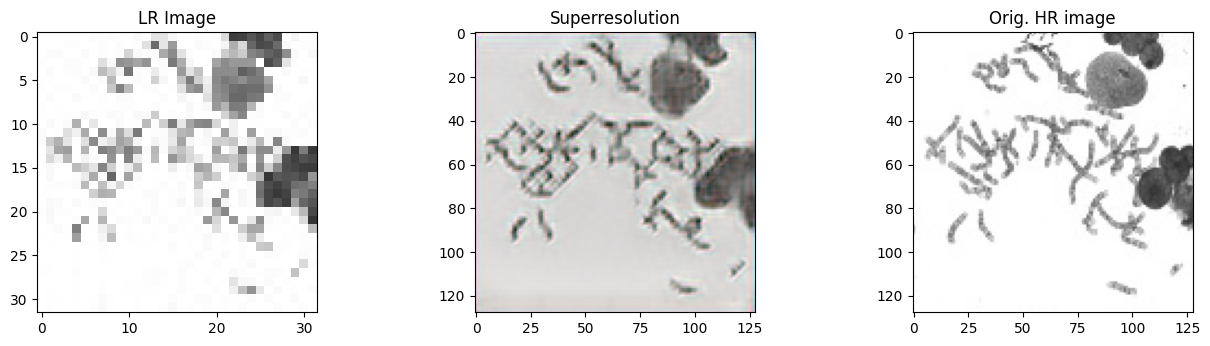

Done with testing
1/1 [==============================] - 0s 34ms/step


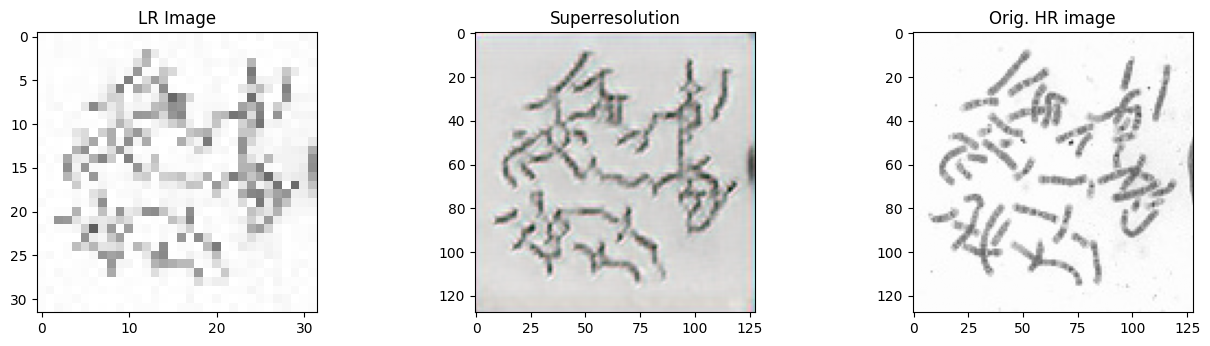

In [14]:
from keras.models import load_model
from numpy.random import randint


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

print("Done with testing")

################################################
sreeni_lr = cv2.imread("/content/train/LR/104022.jpg")
sreeni_hr = cv2.imread("/content/train/HR/104022.jpg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()